# Expression analysis in miRNATissueAtlas

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy.stats import ks_2samp, mannwhitneyu
import matplotlib.pyplot as plt

In [42]:
def extract_df(string, df, handle_col_multiplicity='sum'):
	
	if string != 'all':
		new_df = df.loc[:, df.columns.str.contains(string)]
	else:
		new_df = df.copy()
	
	if handle_col_multiplicity == 'sum':
		new_df = new_df.sum(axis=1)
		new_df = pd.DataFrame(new_df, columns=[f'sum_of_expression_{string}'])
	elif handle_col_multiplicity == 'mean':
		new_df = new_df.mean(axis=1)
		new_df = pd.DataFrame(new_df, columns=[f'mean_of_expression_{string}'])
	else:
		raise ValueError("handle_col_multiplicity must be 'sum' or 'mean'")
	
	return new_df

def filter_idx(lst, df):
	# filter only those rows whose index is in the list
	new_df = df[df.index.isin(lst)]
	return new_df

def compare_expr_boxplot(df1, df2, title1, title2, plot_title, min_y, max_y, jitter=True):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.boxplot([df1.values.flatten(), df2.values.flatten()], showfliers=False)

    # add jittered scatter plots
    if jitter:
        y1 = df1.values.flatten()
        y2 = df2.values.flatten()
        x1 = np.random.normal(1, 0.02, size=len(y1))  # jitter x around position 1
        x2 = np.random.normal(2, 0.02, size=len(y2))  # jitter x around position 2
        ax.scatter(x1, y1, color='red', alpha=0.2, s=10)
        ax.scatter(x2, y2, color='blue', alpha=0.2, s=10)

    ax.set_title(plot_title)
    ax.grid(axis='y')
    ax.set_ylim(min_y, max_y)
    ax.set_xticklabels(['', ''])
    plt.show()

    # Stats
    intro = "Median value of sum of expression in"
    print(f"{intro} {title1}: {round(np.median(df1.values.flatten()), 6)}")
    print(f"{intro} {title2}: {round(np.median(df2.values.flatten()), 6)}")
    print(f"Kolmogorov-Smirnov test:\t{ks_2samp(df1.values.flatten(), df2.values.flatten())}")
    print(f"Mann-Whitney U test:\t\t{mannwhitneyu(df1.values.flatten(), df2.values.flatten())}")

def extract_list(list_of_tuples):
	lst = []
	present = []
	
	for t in list_of_tuples:
	
		if t[0] in present:
			continue
		
		if t[1] in present:
			continue
		
		lst.append(t[0])
		lst.append(t[1])

		present.append(t[0])
		present.append(t[1])

	return lst

def handle_duplicated_rows(df, strategy):

    if strategy not in {'mean', 'max', 'min'}:
        raise ValueError("Strategy must be one of: 'mean', 'max', 'min'")

    return df.groupby(df.index).agg(strategy)

def norm_column(df):
	return df.div(df.sum(axis=0), axis=1)

_________

In [3]:
avg_expr_matrix_path = './all_human_miRNA_rpmm_harmonized_meta_data.mgdb.csv'

In [4]:
with open(avg_expr_matrix_path) as f:
    lines = [line.strip().split('\t') for line in f.readlines()[:4]]
    
columns = list(zip(*lines))
merged_header = ['{},{}'.format(columns[i][0], ','.join(columns[i][1:])) for i in range(len(columns))]
h = '\t'.join(merged_header)

In [5]:
avg_expr_matrix_path = './all_human_miRNA_rpmm_harmonized_meta_data.mgdb.csv'
expr_df = pd.read_csv(avg_expr_matrix_path, index_col=None, sep='\t', header=None)
expr_df = expr_df.iloc[4:, :]
expr_df.columns = h.split('\t')
expr_df.set_index(expr_df.columns[0], inplace=True)
expr_df = expr_df[expr_df.index != 'unknown_mirna']
expr_df = expr_df[expr_df.index != 'premirna_not_in_mirgenedb']
expr_df = expr_df.apply(pd.to_numeric)
expr_df = expr_df.loc[:, expr_df.columns.str.endswith('mean')]

expr_df

/tmp/ipykernel_67283/2160559529.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

,"EV,adipose,adipose,mean","EV,airway,epithelium,mean","EV,airway,pharynx,mean","EV,artery,artery,mean","EV,blood,GDM,mean","EV,blood,Molm14,mean","EV,blood,PBMC,mean","EV,blood,THP,mean","EV,blood,blood,mean","EV,blood,plasma,mean",...,"tissue,tongue,tongue,mean","tissue,tonsil,tonsil,mean","tissue,trachea,trachea,mean","tissue,umbilical_cord,huvec,mean","tissue,umbilical_cord,umbilical_cord,mean","tissue,urethra,urethra,mean","tissue,urine,urine,mean","tissue,uterus,uterus,mean","tissue,vaginal_tissue,vaginal_tissue,mean","tissue,vein,vein,mean"
"Biotype,Organ_system,Tissue,Metric",,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,1088.428021,243.546543,0.043313,219.914918,568.125633,194.249264,281.727338,42.597923,137.123529,565.522809,...,1485.267408,1012.027760,2450.948916,2259.509429,1271.972792,2476.532603,467.290950,1236.827140,2437.746786,776.000649
Hsa-Let-7-P1b,6.505383,4.492620,0.000000,47.933493,15.282738,2.515213,0.649421,0.401885,3.789879,3.072286,...,2.586946,5.930494,5.310115,11.823245,10.589435,4.679424,4.812450,6.962467,33.098248,4.027219
Hsa-Let-7-P1c,4.816620,0.000000,0.000000,44.683410,0.308100,12.401268,0.023610,0.000000,1.241202,1.098243,...,3.459201,5.605949,3.207017,11.017460,10.217927,4.434976,2.537118,1.827755,4.520438,1.293623
Hsa-Let-7-P1c,4765.081268,206.162963,0.557305,609.405956,87.788778,1595.478431,91.012267,197.572829,522.647640,1082.661796,...,4764.332005,2030.584158,8786.298873,2077.455856,1362.149626,8060.796190,1114.537047,2994.291358,12096.249358,2990.441585
Hsa-Let-7-P1d,0.582867,0.754825,0.000000,68.443741,0.179697,0.000000,0.000000,0.000000,0.469278,0.381515,...,0.365671,0.565189,1.068588,5.455957,2.780810,0.838106,7.392894,0.204405,1.249168,0.557457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-96-P2,2.985072,1043.589374,6.907106,47.118951,55.192044,33.070895,151.360592,150.744449,425.107901,529.451015,...,310.940806,8656.767830,377.471680,43.859254,1297.497460,123.201543,182.363125,1748.267031,220.295288,207.660570
Hsa-Mir-96-P3,0.000000,2.507751,0.000000,35.292801,1.349744,0.206051,0.037953,0.025759,1.006019,0.453172,...,12.403298,9.526723,1.988102,0.032581,4.613867,1.466685,1.849835,0.908452,2.879971,0.497193
Hsa-Mir-96-P3,0.747757,842.679437,5.148449,36.157231,34.706521,22.573360,13.384168,96.518346,150.865892,346.188089,...,219.570064,593.713919,112.203670,4.740391,437.259549,43.511656,77.749900,174.234731,93.439187,60.275389


In [6]:
expr_df_avg = handle_duplicated_rows(expr_df, 'mean')
expr_df_avg

,"EV,adipose,adipose,mean","EV,airway,epithelium,mean","EV,airway,pharynx,mean","EV,artery,artery,mean","EV,blood,GDM,mean","EV,blood,Molm14,mean","EV,blood,PBMC,mean","EV,blood,THP,mean","EV,blood,blood,mean","EV,blood,plasma,mean",...,"tissue,tongue,tongue,mean","tissue,tonsil,tonsil,mean","tissue,trachea,trachea,mean","tissue,umbilical_cord,huvec,mean","tissue,umbilical_cord,umbilical_cord,mean","tissue,urethra,urethra,mean","tissue,urine,urine,mean","tissue,uterus,uterus,mean","tissue,vaginal_tissue,vaginal_tissue,mean","tissue,vein,vein,mean"
"Biotype,Organ_system,Tissue,Metric",,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,547.466702,124.019582,0.021657,133.924206,291.704185,98.382238,141.188380,21.499904,70.456704,284.297547,...,743.927177,508.979127,1228.129515,1135.666337,641.281113,1240.606013,236.051700,621.894804,1235.422517,390.013934
Hsa-Let-7-P1c,2384.948944,103.081481,0.278653,327.044683,44.048439,803.939849,45.517938,98.786414,261.944421,541.880020,...,2383.895603,1018.095053,4394.752945,1044.236658,686.183776,4032.615583,558.537082,1498.059557,6050.384898,1495.867604
Hsa-Let-7-P1d,5371.919678,1765.563904,3.266764,507.047889,1204.705255,14065.540419,7837.714163,1516.456772,1580.991433,8258.436257,...,20104.139816,14431.840738,29551.913246,7654.003527,4581.824811,14538.899543,2682.235078,9789.778836,15470.905426,7397.824723
Hsa-Let-7-P2a1,5412.119455,1791.302880,3.266764,503.575495,1242.749562,14629.048061,7845.698765,1535.964167,1597.390602,8273.277945,...,20170.486434,14492.783993,29645.287493,7675.528032,4617.664002,14603.154316,2695.520763,9811.544458,15487.586489,7419.844382
Hsa-Let-7-P2a2,5412.119455,1791.302880,3.266764,503.575495,1242.749562,14629.048061,7845.698765,1535.964167,1597.390602,8273.277945,...,20170.486434,14492.783993,29645.287493,7675.528032,4617.664002,14603.154316,2695.520763,9811.544458,15487.586489,7419.844382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-95,18.213549,23.770848,0.000000,49.810573,4.907014,11.063857,1.679089,23.177767,2.838304,9.631934,...,145.691115,19.323241,31.897171,0.627706,2.305543,34.344875,23.937715,5.653909,8.819852,28.689626
Hsa-Mir-96-P1,0.000000,64.345591,0.000000,41.528149,37.452716,4.742340,1.780925,7.714999,24.818732,16.191713,...,25.671109,19.008276,64.107965,0.301924,110.892109,17.774826,36.154335,17.139664,38.010722,32.451767
Hsa-Mir-96-P2,1.492536,522.816207,3.453553,42.586950,27.796394,16.655445,75.681893,75.488381,212.764980,264.812883,...,156.838587,4328.797649,189.654329,21.932415,649.570598,61.845219,91.894958,874.232008,110.292489,103.911375


In [7]:
expr_df_avg_norm = norm_column(expr_df_avg)
expr_df_avg_norm

,"EV,adipose,adipose,mean","EV,airway,epithelium,mean","EV,airway,pharynx,mean","EV,artery,artery,mean","EV,blood,GDM,mean","EV,blood,Molm14,mean","EV,blood,PBMC,mean","EV,blood,THP,mean","EV,blood,blood,mean","EV,blood,plasma,mean",...,"tissue,tongue,tongue,mean","tissue,tonsil,tonsil,mean","tissue,trachea,trachea,mean","tissue,umbilical_cord,huvec,mean","tissue,umbilical_cord,umbilical_cord,mean","tissue,urethra,urethra,mean","tissue,urine,urine,mean","tissue,uterus,uterus,mean","tissue,vaginal_tissue,vaginal_tissue,mean","tissue,vein,vein,mean"
"Biotype,Organ_system,Tissue,Metric",,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,0.003163,1.123968e-03,0.000004,0.000892,0.000736,0.000227,0.000607,0.000482,0.000453,1.066434e-03,...,0.001616,0.000954,0.002101,4.072032e-03,0.002434,0.002025,0.001746,0.001941,0.002790,0.000756
Hsa-Let-7-P1c,0.013780,9.342094e-04,0.000055,0.002177,0.000111,0.001853,0.000196,0.002214,0.001685,2.032656e-03,...,0.005180,0.001908,0.007519,3.744203e-03,0.002605,0.006582,0.004132,0.004675,0.013663,0.002899
Hsa-Let-7-P1d,0.031038,1.600100e-02,0.000643,0.003376,0.003040,0.032427,0.033694,0.033994,0.010168,3.097838e-02,...,0.043681,0.027051,0.050558,2.744410e-02,0.017392,0.023730,0.019842,0.030553,0.034935,0.014337
Hsa-Let-7-P2a1,0.031270,1.623426e-02,0.000643,0.003353,0.003136,0.033727,0.033728,0.034431,0.010274,3.103405e-02,...,0.043825,0.027165,0.050718,2.752128e-02,0.017528,0.023835,0.019941,0.030621,0.034973,0.014380
Hsa-Let-7-P2a2,0.031270,1.623426e-02,0.000643,0.003353,0.003136,0.033727,0.033728,0.034431,0.010274,3.103405e-02,...,0.043825,0.027165,0.050718,2.752128e-02,0.017528,0.023835,0.019941,0.030621,0.034973,0.014380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-95,0.000105,2.154310e-04,0.000000,0.000332,0.000012,0.000026,0.000007,0.000520,0.000018,3.613053e-05,...,0.000317,0.000036,0.000055,2.250695e-06,0.000009,0.000056,0.000177,0.000018,0.000020,0.000056
Hsa-Mir-96-P1,0.000000,5.831528e-04,0.000000,0.000276,0.000095,0.000011,0.000008,0.000173,0.000160,6.073704e-05,...,0.000056,0.000036,0.000110,1.082577e-06,0.000421,0.000029,0.000267,0.000053,0.000086,0.000063
Hsa-Mir-96-P2,0.000009,4.738192e-03,0.000680,0.000284,0.000070,0.000038,0.000325,0.001692,0.001368,9.933446e-04,...,0.000341,0.008114,0.000324,7.864060e-05,0.002466,0.000101,0.000680,0.002728,0.000249,0.000201


__________________________________

In [8]:
df_to_use = expr_df_avg_norm
df_to_use

,"EV,adipose,adipose,mean","EV,airway,epithelium,mean","EV,airway,pharynx,mean","EV,artery,artery,mean","EV,blood,GDM,mean","EV,blood,Molm14,mean","EV,blood,PBMC,mean","EV,blood,THP,mean","EV,blood,blood,mean","EV,blood,plasma,mean",...,"tissue,tongue,tongue,mean","tissue,tonsil,tonsil,mean","tissue,trachea,trachea,mean","tissue,umbilical_cord,huvec,mean","tissue,umbilical_cord,umbilical_cord,mean","tissue,urethra,urethra,mean","tissue,urine,urine,mean","tissue,uterus,uterus,mean","tissue,vaginal_tissue,vaginal_tissue,mean","tissue,vein,vein,mean"
"Biotype,Organ_system,Tissue,Metric",,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,0.003163,1.123968e-03,0.000004,0.000892,0.000736,0.000227,0.000607,0.000482,0.000453,1.066434e-03,...,0.001616,0.000954,0.002101,4.072032e-03,0.002434,0.002025,0.001746,0.001941,0.002790,0.000756
Hsa-Let-7-P1c,0.013780,9.342094e-04,0.000055,0.002177,0.000111,0.001853,0.000196,0.002214,0.001685,2.032656e-03,...,0.005180,0.001908,0.007519,3.744203e-03,0.002605,0.006582,0.004132,0.004675,0.013663,0.002899
Hsa-Let-7-P1d,0.031038,1.600100e-02,0.000643,0.003376,0.003040,0.032427,0.033694,0.033994,0.010168,3.097838e-02,...,0.043681,0.027051,0.050558,2.744410e-02,0.017392,0.023730,0.019842,0.030553,0.034935,0.014337
Hsa-Let-7-P2a1,0.031270,1.623426e-02,0.000643,0.003353,0.003136,0.033727,0.033728,0.034431,0.010274,3.103405e-02,...,0.043825,0.027165,0.050718,2.752128e-02,0.017528,0.023835,0.019941,0.030621,0.034973,0.014380
Hsa-Let-7-P2a2,0.031270,1.623426e-02,0.000643,0.003353,0.003136,0.033727,0.033728,0.034431,0.010274,3.103405e-02,...,0.043825,0.027165,0.050718,2.752128e-02,0.017528,0.023835,0.019941,0.030621,0.034973,0.014380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-95,0.000105,2.154310e-04,0.000000,0.000332,0.000012,0.000026,0.000007,0.000520,0.000018,3.613053e-05,...,0.000317,0.000036,0.000055,2.250695e-06,0.000009,0.000056,0.000177,0.000018,0.000020,0.000056
Hsa-Mir-96-P1,0.000000,5.831528e-04,0.000000,0.000276,0.000095,0.000011,0.000008,0.000173,0.000160,6.073704e-05,...,0.000056,0.000036,0.000110,1.082577e-06,0.000421,0.000029,0.000267,0.000053,0.000086,0.000063
Hsa-Mir-96-P2,0.000009,4.738192e-03,0.000680,0.000284,0.000070,0.000038,0.000325,0.001692,0.001368,9.933446e-04,...,0.000341,0.008114,0.000324,7.864060e-05,0.002466,0.000101,0.000680,0.002728,0.000249,0.000201


In [9]:
df_to_use_sum = df_to_use.sum(axis=1)
df_to_use_sum = pd.DataFrame(df_to_use, columns=['sum_of_expression'])
df_to_use_sum

,sum_of_expression
"Biotype,Organ_system,Tissue,Metric",
Hsa-Let-7-P1b,NaN
Hsa-Let-7-P1c,NaN
Hsa-Let-7-P1d,NaN
Hsa-Let-7-P2a1,NaN
Hsa-Let-7-P2a2,NaN
...,...
Hsa-Mir-95,NaN
Hsa-Mir-96-P1,NaN
Hsa-Mir-96-P2,NaN


In [35]:
df_to_use_avg = df_to_use.mean(axis=1)
df_to_use_avg = pd.DataFrame(df_to_use, columns=['mean_of_expression'])
df_to_use_avg

,mean_of_expression
"Biotype,Organ_system,Tissue,Metric",
Hsa-Let-7-P1b,NaN
Hsa-Let-7-P1c,NaN
Hsa-Let-7-P1d,NaN
Hsa-Let-7-P2a1,NaN
Hsa-Let-7-P2a2,NaN
...,...
Hsa-Mir-95,NaN
Hsa-Mir-96-P1,NaN
Hsa-Mir-96-P2,NaN


_________________________________________

## Parse duplicate miRNAs

In [10]:
mirna_origin_file_path = '../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[0, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

print("Test on 'Hsa-Let-7-P1d': ", mirna_lno_dict['Hsa-Let-7-P1d'][0])

pre_2R_clades = ['Bilateria', 
                'Chordata', 
                'Eumetazoa', 
                'Vertebrata', 
                'Nephrozoa', 
                'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

Test on 'Hsa-Let-7-P1d':  Bilateria


In [11]:
om_pairs_path = f'../Motif_analysis/PPI_Bifan/ohnomirna_pairs_predict_Hsa_existent.names.extended_info.flagged_WGD_host_genes.tsv'
pm_pairs_path = f'../3_retrieve_Hsa_paralogs/mgdb_3_hsa.premirna_paralog_pairs.extended_info.tsv'

om_pairs_df = pd.read_csv(om_pairs_path, sep='\t', header=0)
pm_pairs_df = pd.read_csv(pm_pairs_path, sep='\t', header=None)

print("Number of pairs BEFORE 2R filtering:", pm_pairs_df.shape[0])

pm_pairs_pre2R_df = pm_pairs_df[~pm_pairs_df[0].apply(all_clades_in_pre2R) | ~pm_pairs_df[1].apply(all_clades_in_pre2R)]
pm_pairs_post2R_df = pm_pairs_df[pm_pairs_df[0].apply(all_clades_in_pre2R) & pm_pairs_df[1].apply(all_clades_in_pre2R)]

print("Number of pairs AFTER 2R filtering:", pm_pairs_pre2R_df.shape[0], "\npost2R pairs:", pm_pairs_post2R_df.shape[0])

om_pairs_intragenic_df = om_pairs_df[~om_pairs_df['host_gene_name_1'].isin(['intergenic']) & ~om_pairs_df['host_gene_name_2'].isin(['intergenic'])]
om_pairs_intergenic_df = om_pairs_df[om_pairs_df['host_gene_name_1'].isin(['intergenic']) | om_pairs_df['host_gene_name_2'].isin(['intergenic'])]

Number of pairs BEFORE 2R filtering: 2655
Number of pairs AFTER 2R filtering: 879 
post2R pairs: 1776


In [12]:
om_pairs = om_pairs_df.iloc[:, [0, 7]].values
om_pairs = [tuple(sorted(pair)) for pair in om_pairs]
om_pairs = list(set(om_pairs))
print(f"Number of om pairs: {len(om_pairs)}", file=sys.stderr)

om_pairs_intragenic = om_pairs_intragenic_df.iloc[:, [0, 7]].values
om_pairs_intragenic = [tuple(sorted(pair)) for pair in om_pairs_intragenic]
om_pairs_intragenic = list(set(om_pairs_intragenic))
print(f"Number of om pairs intragenic: {len(om_pairs_intragenic)}", file=sys.stderr)

om_pairs_intergenic = om_pairs_intergenic_df.iloc[:, [0, 7]].values
om_pairs_intergenic = [tuple(sorted(pair)) for pair in om_pairs_intergenic]
om_pairs_intergenic = list(set(om_pairs_intergenic))
print(f"Number of om pairs intergenic: {len(om_pairs_intergenic)}", file=sys.stderr)

print(100*"=", file=sys.stderr)

pm_pairs = pm_pairs_df.iloc[:, [0, 5]].values
pm_pairs = [tuple(sorted(pair)) for pair in pm_pairs]
pm_pairs = list(set(pm_pairs))
print(f"Number of pm pairs: {len(pm_pairs)}", file=sys.stderr)

pm_pairs_pre2R = pm_pairs_pre2R_df.iloc[:, [0, 5]].values
pm_pairs_pre2R = [tuple(sorted(pair)) for pair in pm_pairs_pre2R]
pm_pairs_pre2R = list(set(pm_pairs_pre2R))
print(f"Number of pre2R pm pairs: {len(pm_pairs_pre2R)}", file=sys.stderr)

pm_pairs_pre2R = [pair for pair in pm_pairs_pre2R if pair not in om_pairs]
print(f"Number of pre2R pm pairs after filtering out om pairs: {len(pm_pairs_pre2R)}", file=sys.stderr)

pm_pairs_post2R = pm_pairs_post2R_df.iloc[:, [0, 5]].values
pm_pairs_post2R = [tuple(sorted(pair)) for pair in pm_pairs_post2R]
pm_pairs_post2R = list(set(pm_pairs_post2R))
print(f"Number of post2R pm pairs: {len(pm_pairs_post2R)}", file=sys.stderr)

pm_pairs_post2R = [pair for pair in pm_pairs_post2R if pair not in om_pairs]
print(f"Number of post2R pm pairs post2R after filtering out om pairs: {len(pm_pairs_post2R)}", file=sys.stderr)

Number of om pairs: 114
Number of om pairs intragenic: 25
Number of om pairs intergenic: 89
Number of pm pairs: 2467
Number of pre2R pm pairs: 798
Number of pre2R pm pairs after filtering out om pairs: 783
Number of post2R pm pairs: 1669
Number of post2R pm pairs post2R after filtering out om pairs: 1570


In [13]:
om_list = extract_list(om_pairs)
pm_list = extract_list(pm_pairs)
om_list_intragenic = extract_list(om_pairs_intragenic)
om_list_intergenic = extract_list(om_pairs_intergenic)
pm_list_pre2R = extract_list(pm_pairs_pre2R)
pm_list_post2R = extract_list(pm_pairs_post2R)

# remove prom pm_list those that are in om_list
pm_list_pre2R = [m for m in pm_list_pre2R if m not in om_list]
pm_list_post2R = [m for m in pm_list_post2R if m not in om_list]
pm_list = [m for m in pm_list if m not in om_list]

for lst,l in [(om_list, 'om'), (om_list_intragenic, 'intragenic om'), (om_list_intergenic, 'intergenic om')]:
	print(f"Number of unique {l} elements: {len(lst)}", file=sys.stderr)

print(100*"=", file=sys.stderr)

for lst,l in [(pm_list, 'pm'), (pm_list_pre2R, 'pre-2R pm'), (pm_list_post2R, 'post-2R pm')]:
	print(f"Number of unique {l} elements: {len(lst)}", file=sys.stderr)


Number of unique om elements: 112
Number of unique intragenic om elements: 34
Number of unique intergenic om elements: 88
Number of unique pm elements: 177
Number of unique pre-2R pm elements: 80
Number of unique post-2R pm elements: 93


In [14]:
# extract a list of miRNAs that contains the string "Mir-430" (check both in om and pm)
om_list_mir430 = [m for m in om_list if 'Mir-430' in m]
pm_list_mir430 = [m for m in pm_list if 'Mir-430' in m]
mir430 = list(set(om_list_mir430).union(pm_list_mir430))

mir430

['Hsa-Mir-430-P37b',
 'Hsa-Mir-430-P16b',
 'Hsa-Mir-430-P21',
 'Hsa-Mir-430-P13',
 'Hsa-Mir-430-P11',
 'Hsa-Mir-430-P8a',
 'Hsa-Mir-430-P26',
 'Hsa-Mir-430-P17',
 'Hsa-Mir-430-P1',
 'Hsa-Mir-430-P32',
 'Hsa-Mir-430-P41b',
 'Hsa-Mir-430-P37a',
 'Hsa-Mir-430-P38',
 'Hsa-Mir-430-P23',
 'Hsa-Mir-430-P6',
 'Hsa-Mir-430-P18',
 'Hsa-Mir-430-P20',
 'Hsa-Mir-430-P29c',
 'Hsa-Mir-430-P12a',
 'Hsa-Mir-430-P41a',
 'Hsa-Mir-430-P27',
 'Hsa-Mir-430-P8b',
 'Hsa-Mir-430-P3',
 'Hsa-Mir-430-P9',
 'Hsa-Mir-430-P2',
 'Hsa-Mir-430-P14',
 'Hsa-Mir-430-P35',
 'Hsa-Mir-430-P15',
 'Hsa-Mir-430-P28',
 'Hsa-Mir-430-P29b',
 'Hsa-Mir-430-P34b',
 'Hsa-Mir-430-P22',
 'Hsa-Mir-430-P37c',
 'Hsa-Mir-430-P31a',
 'Hsa-Mir-430-P4',
 'Hsa-Mir-430-P31b',
 'Hsa-Mir-430-P30',
 'Hsa-Mir-430-P19',
 'Hsa-Mir-430-P5',
 'Hsa-Mir-430-P40a',
 'Hsa-Mir-430-P39',
 'Hsa-Mir-430-P33b',
 'Hsa-Mir-430-P36',
 'Hsa-Mir-430-P25',
 'Hsa-Mir-430-P7',
 'Hsa-Mir-430-P24',
 'Hsa-Mir-430-P40b',
 'Hsa-Mir-430-P12b',
 'Hsa-Mir-430-P29a',
 'Hsa-Mir-4

In [15]:
df_o = filter_idx(om_list, df_to_use)
df_p = filter_idx(pm_list, df_to_use)

print(f"Number of om miRNAs: {len(df_o)}")
print(f"Number of pm miRNAs: {len(df_p)}")

Number of om miRNAs: 112
Number of pm miRNAs: 174


In [16]:
df_430 = filter_idx(mir430, df_to_use)
print(f"Number of miRNAs in mir430: {len(df_430)}")

Number of miRNAs in mir430: 52


In [17]:
df_pm_pre2R = filter_idx(pm_list_pre2R, df_to_use)
print(f"Number of pm miRNAs pre2R: {len(df_pm_pre2R)}")

df_pm_post2R = filter_idx(pm_list_post2R, df_to_use)
print(f"Number of pm miRNAs post2R: {len(df_pm_post2R)}")

Number of pm miRNAs pre2R: 79
Number of pm miRNAs post2R: 91


____________________________________________

## WGD-SSD expression comparison

The miRNATissueAtlas database contains 3 macro-categories of expression data:
- Tissues
- EVs (extracellular vesicles)
- Cell lines

## Tissues

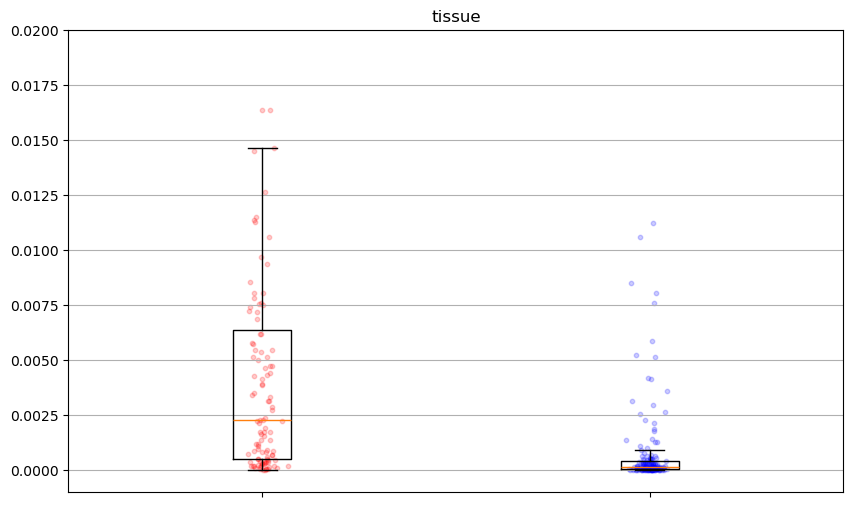

Median value of sum of expression in WGD: 0.002263
Median value of sum of expression in SSD: 0.000124
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5538793103448276, pvalue=8.546243962724332e-20, statistic_location=0.00034979726722263936, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=16186.0, pvalue=3.899706317063281e-21)


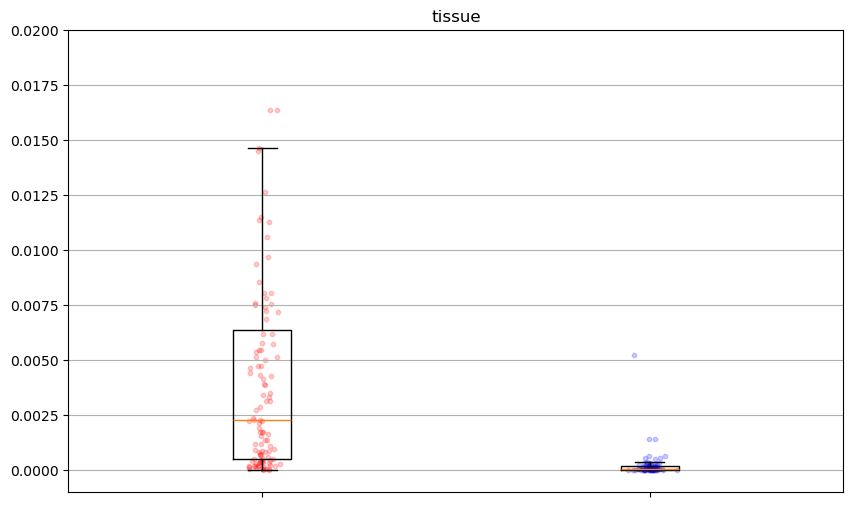

Median value of sum of expression in WGD: 0.002263
Median value of sum of expression in SSD (pre 2R): 5.2e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.7112341772151899, pvalue=3.8400837519698067e-23, statistic_location=0.00035407047263674734, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8063.0, pvalue=4.0297501564465645e-22)


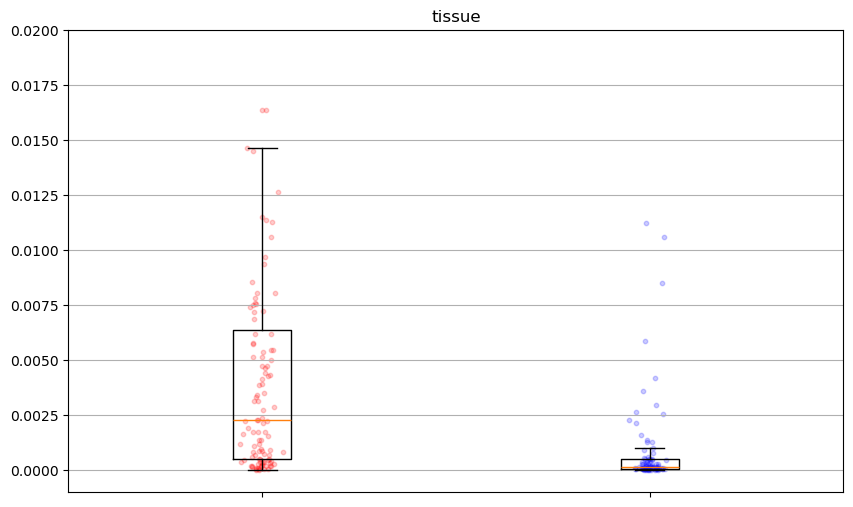

Median value of sum of expression in WGD: 0.002263
Median value of sum of expression in SSD (post 2R): 0.000165
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5054945054945055, pvalue=3.1569667956007116e-12, statistic_location=0.0005956587291508644, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8232.0, pvalue=4.96784520667684e-14)


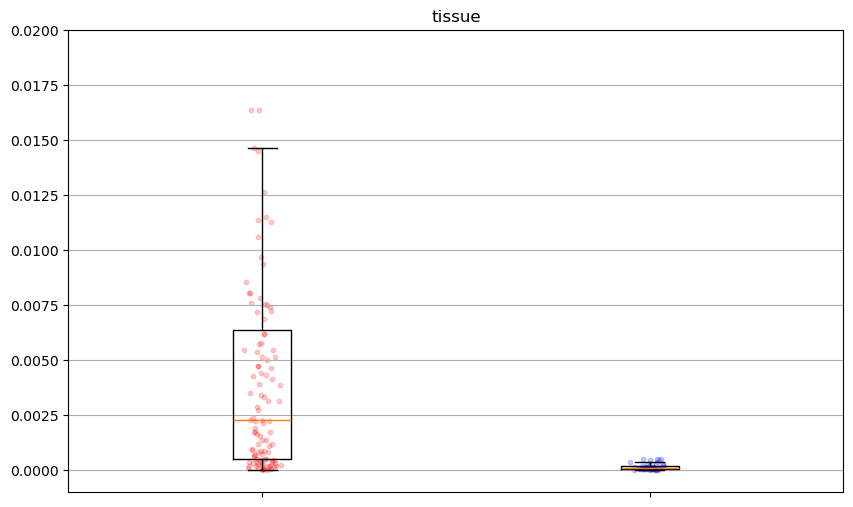

Median value of sum of expression in WGD: 0.002263
Median value of sum of expression in SSD (Mir-430): 0.000104
Kolmogorov-Smirnov test:	KstestResult(statistic=0.7232142857142857, pvalue=1.2587594159482577e-18, statistic_location=0.0005169616044166607, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5331.0, pvalue=1.2690519028660414e-17)


In [44]:
label = 'tissue'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Extracellular vescicles (EV)

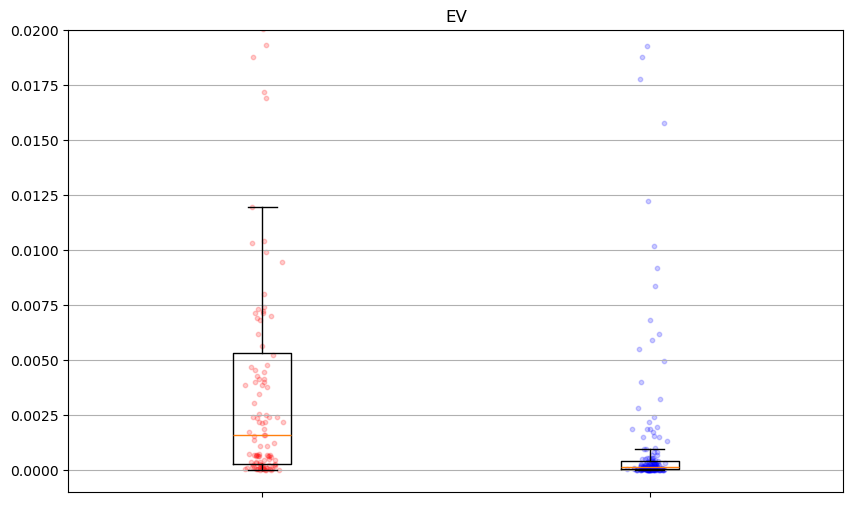

Median value of sum of expression in WGD: 0.001597
Median value of sum of expression in SSD: 0.000121
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4684934318555008, pvalue=4.391390879177824e-14, statistic_location=0.0005460485176593643, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=14999.0, pvalue=1.3973400888352646e-14)


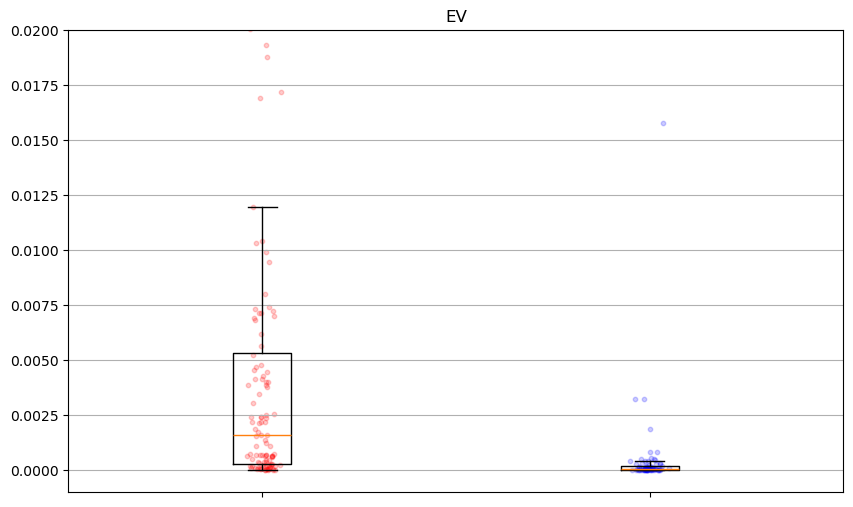

Median value of sum of expression in WGD: 0.001597
Median value of sum of expression in SSD (pre 2R): 4.5e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5936934900542495, pvalue=9.202685818245052e-16, statistic_location=0.0005292272613756003, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7571.0, pvalue=6.128605431761641e-17)


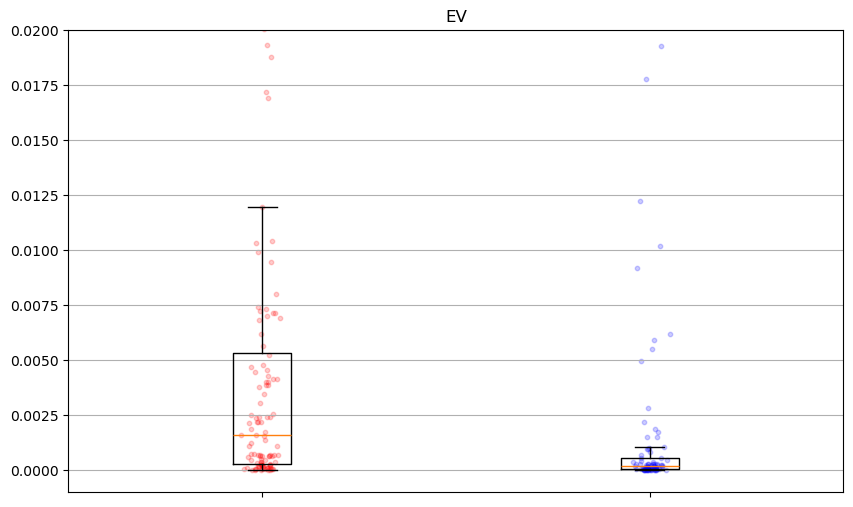

Median value of sum of expression in WGD: 0.001597
Median value of sum of expression in SSD (post 2R): 0.000168
Kolmogorov-Smirnov test:	KstestResult(statistic=0.42857142857142855, pvalue=8.151380977041086e-09, statistic_location=0.00037661267217075424, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7511.0, pvalue=6.6069207073567545e-09)


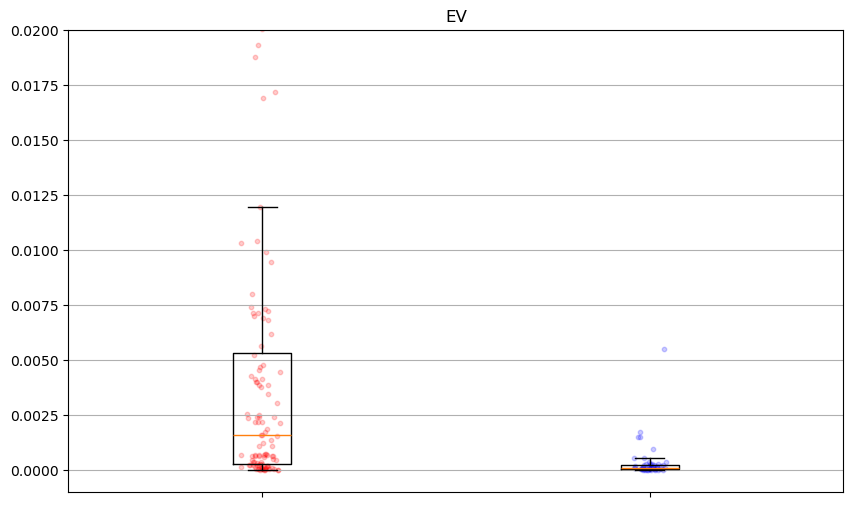

Median value of sum of expression in WGD: 0.001597
Median value of sum of expression in Mir-430: 0.000118
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5796703296703297, pvalue=1.251266580819094e-11, statistic_location=0.00037661267217075424, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=4764.0, pvalue=6.037151136751024e-11)


In [45]:
label = 'EV'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'Mir-430', f'{label}', -0.001, 0.02)

## Cell lines

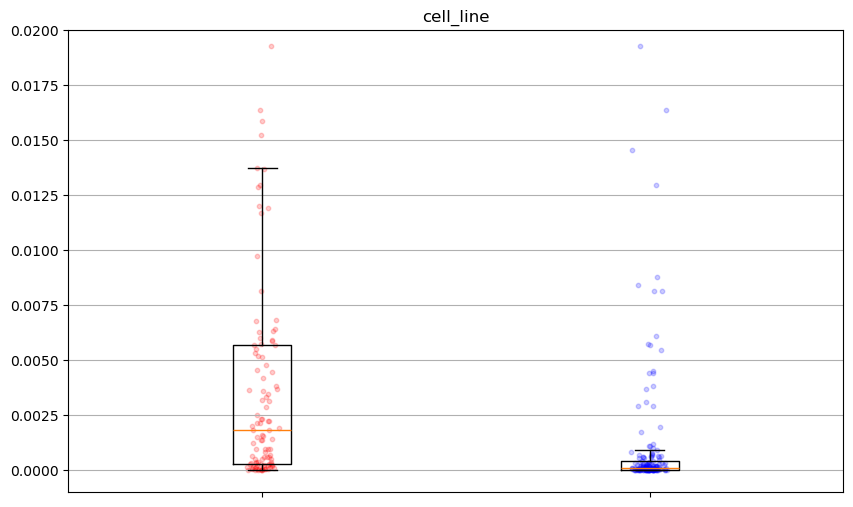

Median value of sum of expression in WGD: 0.001814
Median value of sum of expression in SSD: 0.000106
Kolmogorov-Smirnov test:	KstestResult(statistic=0.46449096880131363, pvalue=7.971379201688558e-14, statistic_location=0.00022363904012552105, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15160.0, pvalue=2.149034443545508e-15)


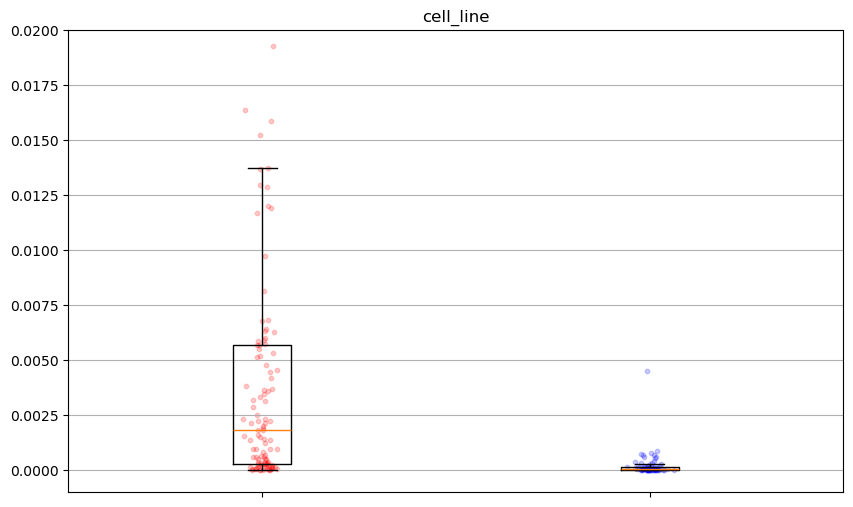

Median value of sum of expression in WGD: 0.001814
Median value of sum of expression in SSD (pre 2R): 4.6e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6166365280289331, pvalue=4.883215122767208e-17, statistic_location=0.00012915705152211207, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7766.0, pvalue=6.626603572628685e-19)


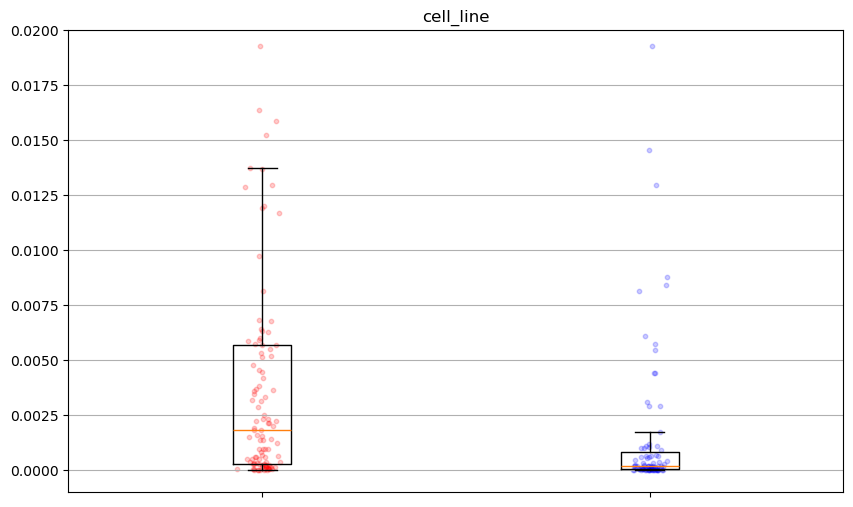

Median value of sum of expression in WGD: 0.001814
Median value of sum of expression in SSD (post 2R): 0.000177
Kolmogorov-Smirnov test:	KstestResult(statistic=0.39697802197802196, pvalue=1.3398836667129772e-07, statistic_location=0.00022363904012552105, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7397.0, pvalue=3.2622185429419217e-08)


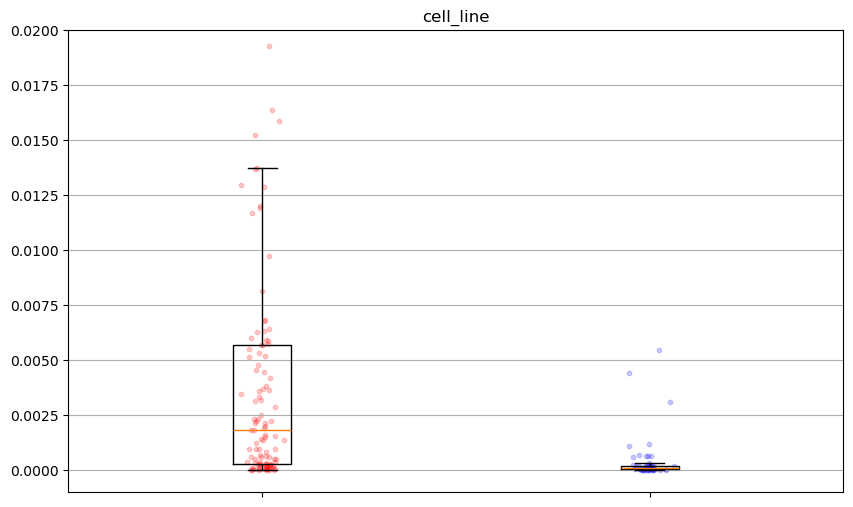

Median value of sum of expression in WGD: 0.001814
Median value of sum of expression in SSD (Mir-430): 0.000111
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5741758241758241, pvalue=2.1046113845814377e-11, statistic_location=0.00024080599044727047, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=4775.0, pvalue=4.651410425481662e-11)


In [46]:
label = 'cell_line'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

_____________________________________

# Tissues

In [47]:
tissues = df_o.columns[df_o.columns.str.startswith('tissue')].tolist()
tissues

['tissue,adipose,adipose,mean',
 'tissue,adrenal_gland,adrenal_gland,mean',
 'tissue,airway,larynx,mean',
 'tissue,airway,pharynx,mean',
 'tissue,aqueous_humor,aqueous_humor,mean',
 'tissue,artery,artery,mean',
 'tissue,bladder,bladder,mean',
 'tissue,blood,PBMC,mean',
 'tissue,blood,blood,mean',
 'tissue,blood,lymphocyte,mean',
 'tissue,blood,plasma,mean',
 'tissue,blood,platelet,mean',
 'tissue,blood,serum,mean',
 'tissue,bone,bone,mean',
 'tissue,bone_marrow,bone_marrow,mean',
 'tissue,bowel,bowel,mean',
 'tissue,bowel,colon,mean',
 'tissue,bowel,duodenum,mean',
 'tissue,bowel,ileum,mean',
 'tissue,bowel,jejunum,mean',
 'tissue,bowel,small_intestine,mean',
 'tissue,brain,arachnoid_mater,mean',
 'tissue,brain,astrocyte,mean',
 'tissue,brain,brain,mean',
 'tissue,brain,cerebellum,mean',
 'tissue,brain,choroid_plexus,mean',
 'tissue,brain,cortex,mean',
 'tissue,brain,dura_matter,mean',
 'tissue,brain,frontal_lobe,mean',
 'tissue,brain,grey_matter,mean',
 'tissue,brain,hippocampus,mean'

## Tissue: Skin

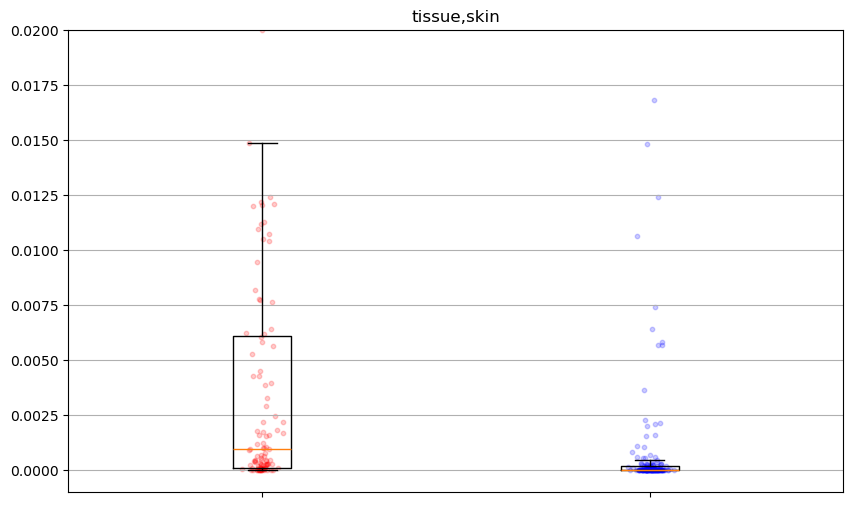

Median value of sum of expression in WGD: 0.000942
Median value of sum of expression in SSD: 1.5e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4964080459770115, pvalue=8.244414477028129e-16, statistic_location=6.706431261761928e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15679.0, pvalue=3.54114116716863e-18)


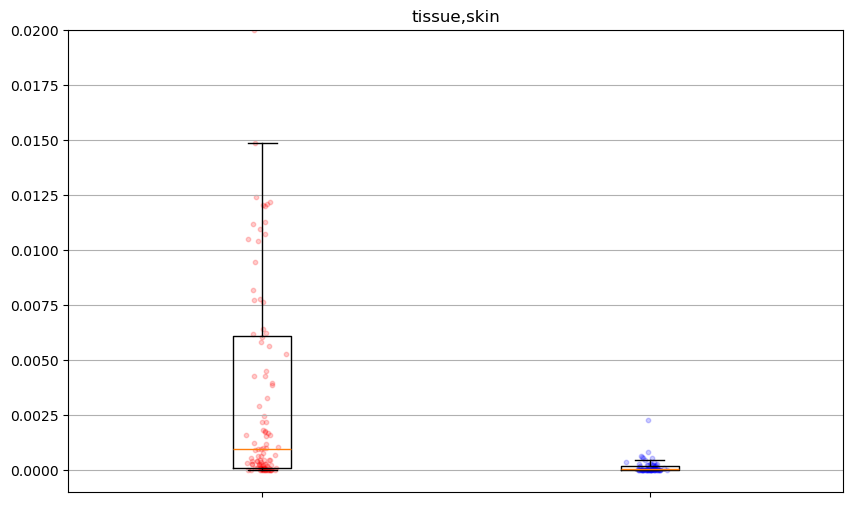

Median value of sum of expression in WGD: 0.000942
Median value of sum of expression in SSD (pre 2R): 3.3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5370705244122965, pvalue=8.346922868232553e-13, statistic_location=0.0002320326838368652, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7272.0, pvalue=3.788778467991141e-14)


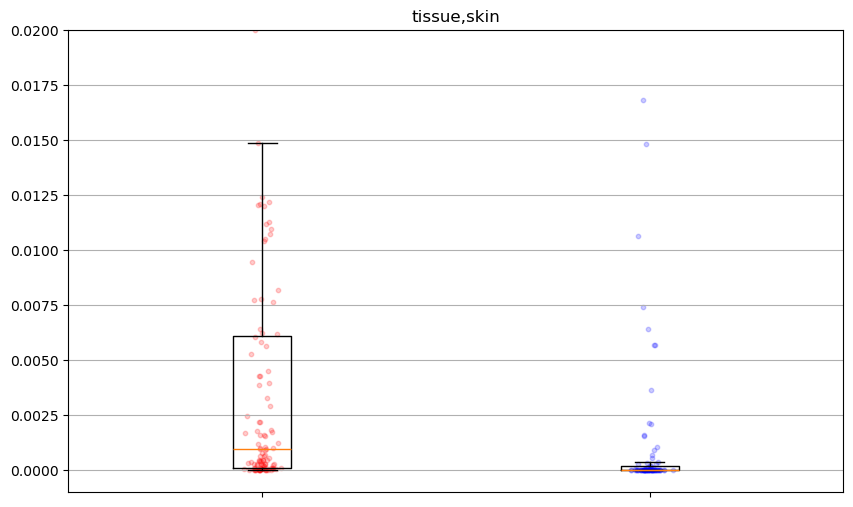

Median value of sum of expression in WGD: 0.000942
Median value of sum of expression in SSD (post 2R): 5e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5590659340659341, pvalue=5.245675232267108e-15, statistic_location=1.1975833597309762e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8302.0, pvalue=1.3507957439428324e-14)


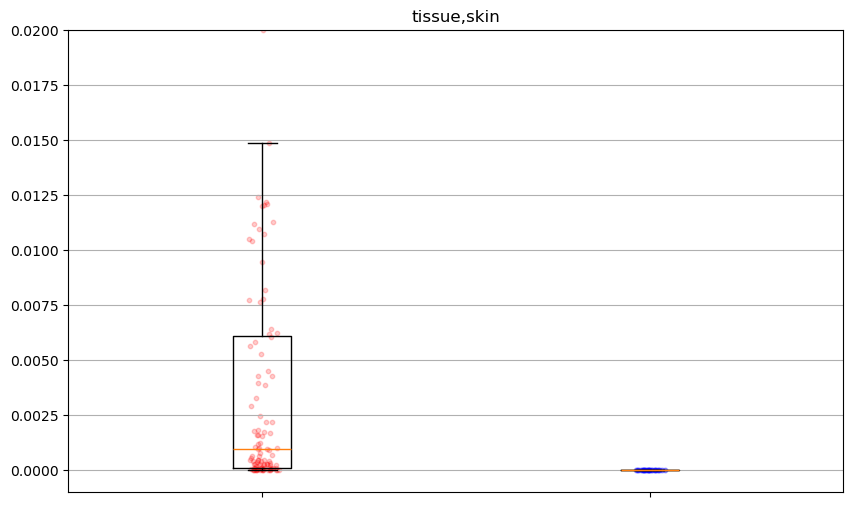

Median value of sum of expression in WGD: 0.000942
Median value of sum of expression in SSD (Mir-430): 2e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.8571428571428571, pvalue=7.7788209786951675e-28, statistic_location=2.824510946383159e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5627.0, pvalue=8.599522312161576e-22)


In [48]:
label = 'tissue,skin'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Tissue: Connective tissue

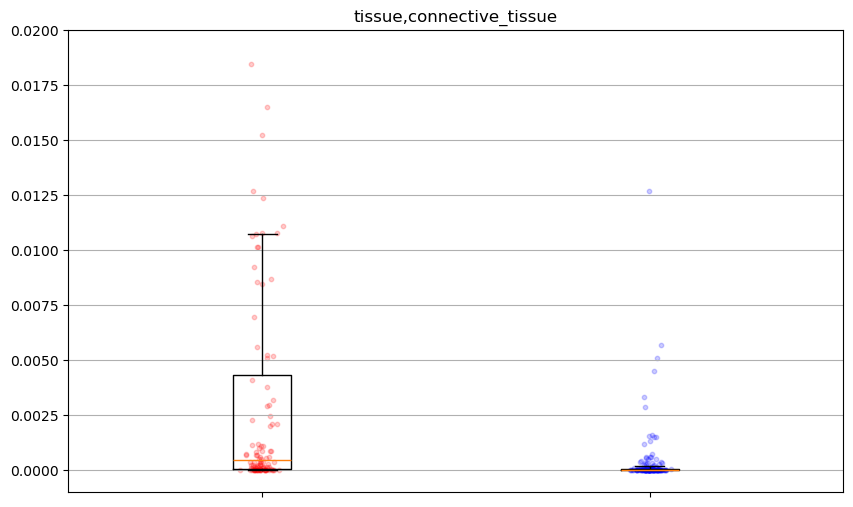

Median value of sum of expression in WGD: 0.000449
Median value of sum of expression in SSD: 5e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.48060344827586204, pvalue=7.964850914803116e-15, statistic_location=0.00011801850954534073, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15287.0, pvalue=4.721661168788298e-16)


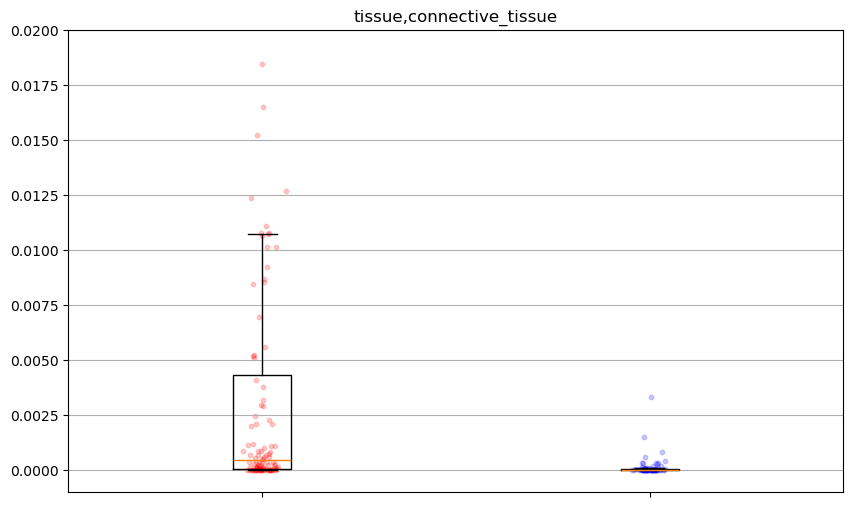

Median value of sum of expression in WGD: 0.000449
Median value of sum of expression in SSD (pre 2R): 1.1e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5229430379746836, pvalue=3.8876372728822636e-12, statistic_location=9.637533758887471e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7088.0, pvalue=1.45183728871493e-12)


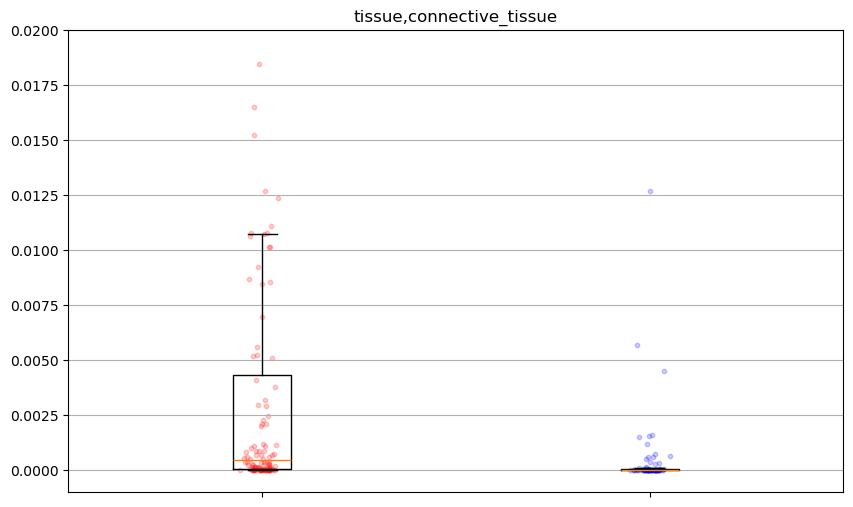

Median value of sum of expression in WGD: 0.000449
Median value of sum of expression in SSD (post 2R): 2e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5467032967032966, pvalue=2.444172214040997e-14, statistic_location=1.654903683773172e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8279.0, pvalue=2.0785294921289192e-14)


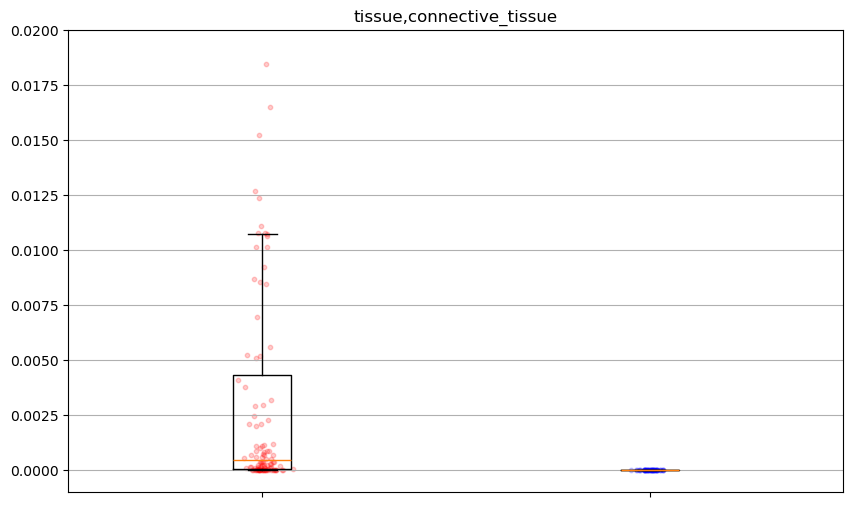

Median value of sum of expression in WGD: 0.000449
Median value of sum of expression in SSD (Mir-430): 1e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.8303571428571429, pvalue=1.0551315569957987e-25, statistic_location=1.3121733441461446e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5421.0, pvalue=7.683713267329582e-19)


In [49]:
label = 'tissue,connective_tissue'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Tissue: Blood

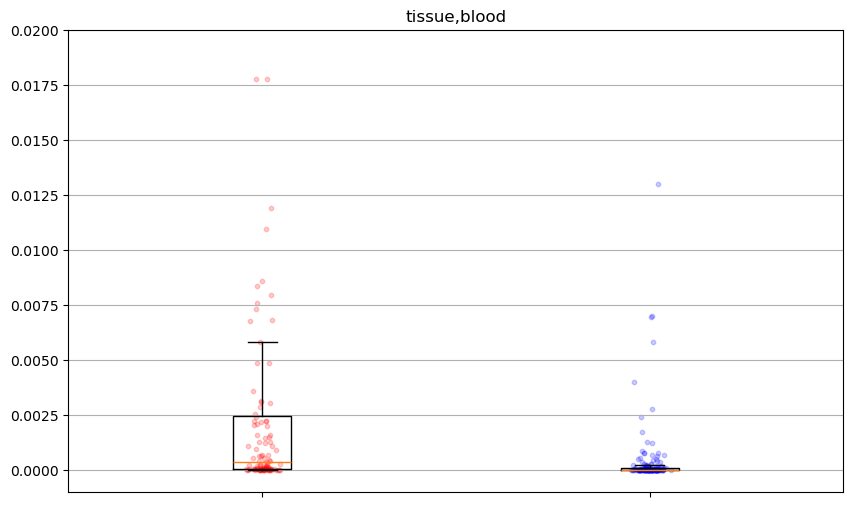

Median value of sum of expression in WGD: 0.000386
Median value of sum of expression in SSD: 1.3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.47393267651888343, pvalue=2.1058938766161265e-14, statistic_location=1.7089591693979767e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15566.0, pvalue=1.5003442567491546e-17)


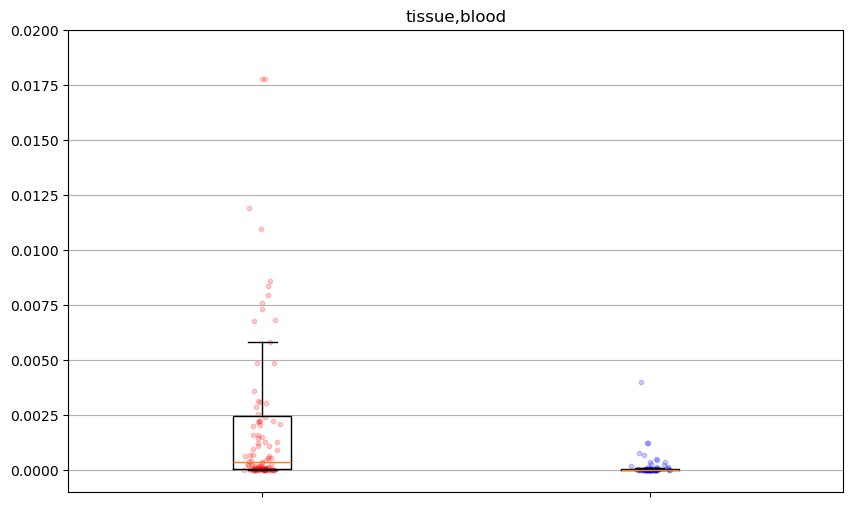

Median value of sum of expression in WGD: 0.000386
Median value of sum of expression in SSD (pre 2R): 2.3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4723101265822785, pvalue=6.758937230295827e-10, statistic_location=6.004828478416493e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7151.0, pvalue=4.2782270523141324e-13)


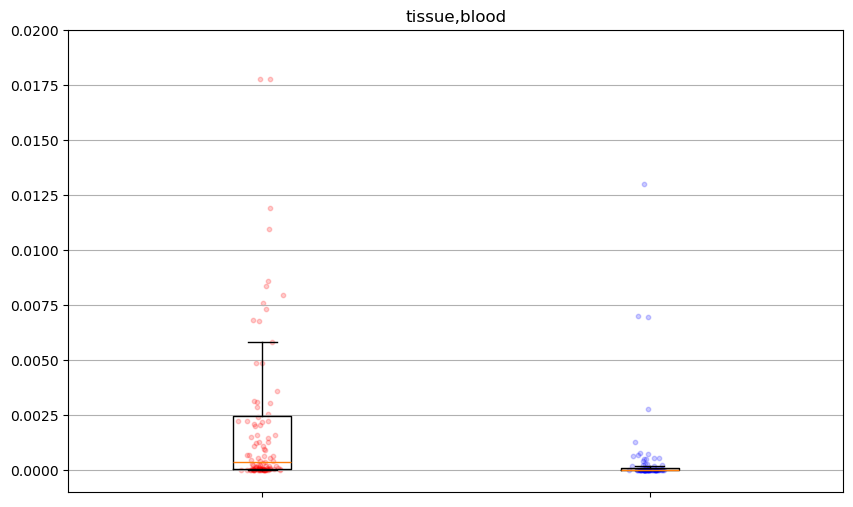

Median value of sum of expression in WGD: 0.000386
Median value of sum of expression in SSD (post 2R): 1e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6105769230769231, pvalue=4.980614291699169e-18, statistic_location=1.1473097575890827e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8391.0, pvalue=2.4776131379614157e-15)


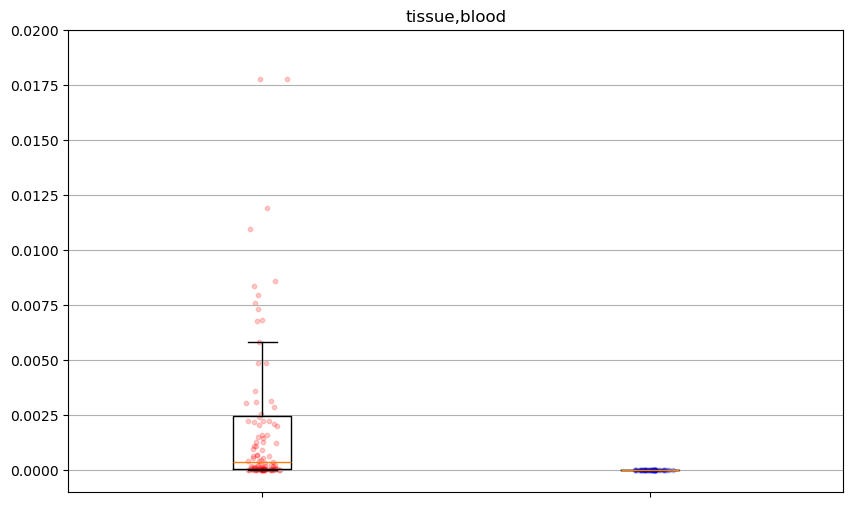

Median value of sum of expression in WGD: 0.000386
Median value of sum of expression in SSD (Mir-430): 6e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.907967032967033, pvalue=4.996844786339994e-32, statistic_location=1.3623030391393791e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5744.0, pvalue=1.4353571481621066e-23)


In [50]:
label = 'tissue,blood'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Tissue: Heart

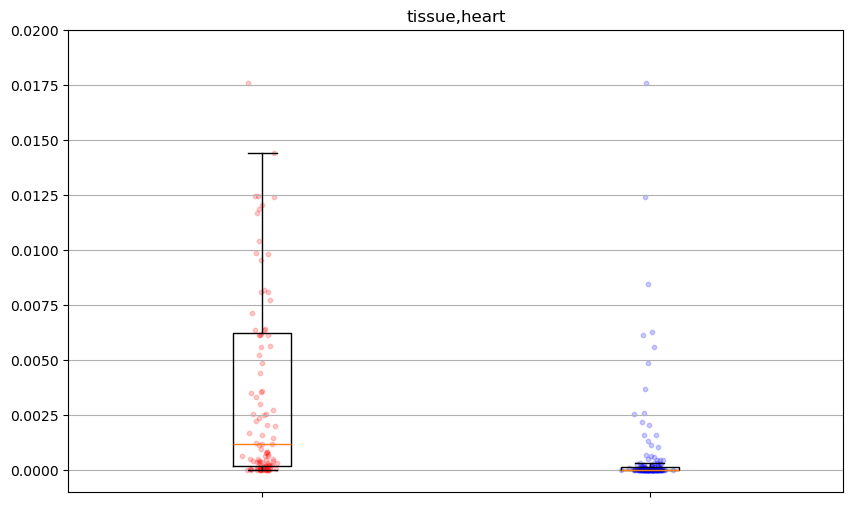

Median value of sum of expression in WGD: 0.001168
Median value of sum of expression in SSD: 1.1e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5470032840722496, pvalue=2.559505520306583e-19, statistic_location=0.0003242370438078053, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=16381.0, pvalue=2.455920031834689e-22)


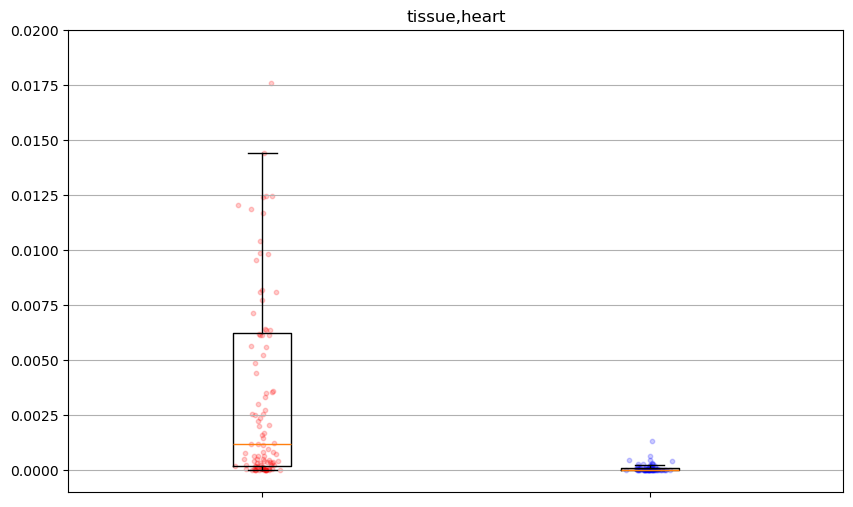

Median value of sum of expression in WGD: 0.001168
Median value of sum of expression in SSD (pre 2R): 1.9e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6331374321880651, pvalue=4.880436490969836e-18, statistic_location=0.00030376211630366896, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7749.0, pvalue=9.937486075474993e-19)


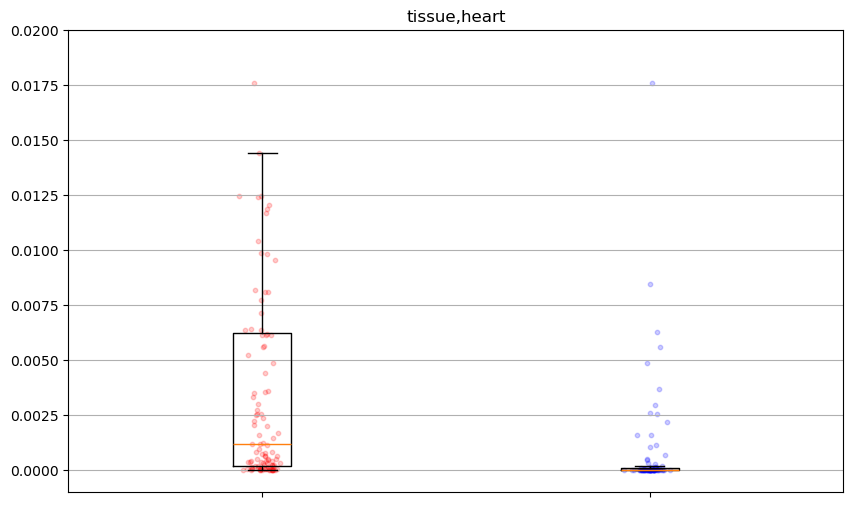

Median value of sum of expression in WGD: 0.001168
Median value of sum of expression in SSD (post 2R): 1e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5693681318681318, pvalue=1.3844775893053251e-15, statistic_location=4.647573111827353e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8656.0, pvalue=1.2162172849290194e-17)


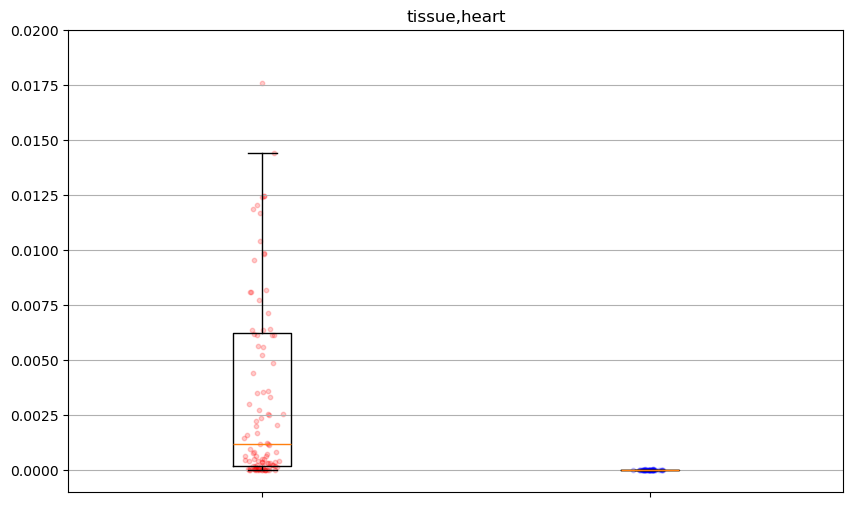

Median value of sum of expression in WGD: 0.001168
Median value of sum of expression in SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.8962912087912088, pvalue=4.138279949465435e-31, statistic_location=4.01375432528716e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5765.0, pvalue=6.762952043589143e-24)


In [51]:
label = 'tissue,heart'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Tissue: Pancreas

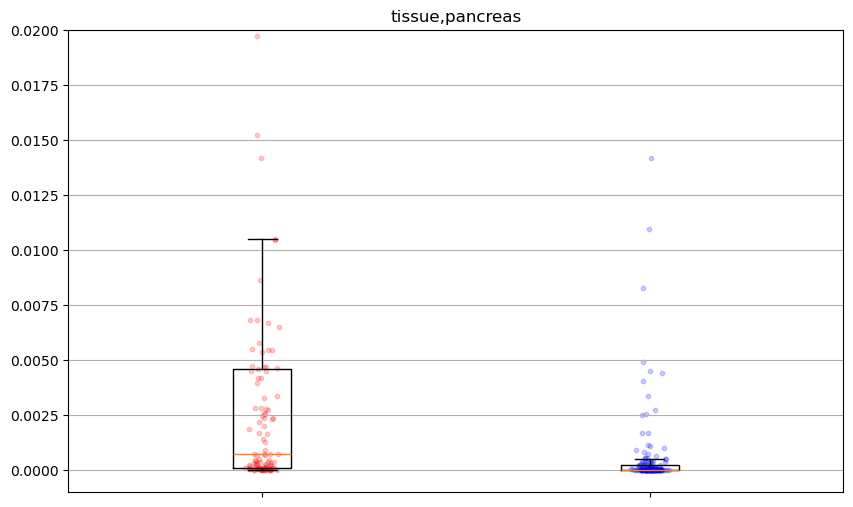

Median value of sum of expression in WGD: 0.00073
Median value of sum of expression in SSD: 1.1e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4822454844006568, pvalue=6.4588026200838586e-15, statistic_location=2.1920212952939605e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15783.0, pvalue=9.154874046585566e-19)


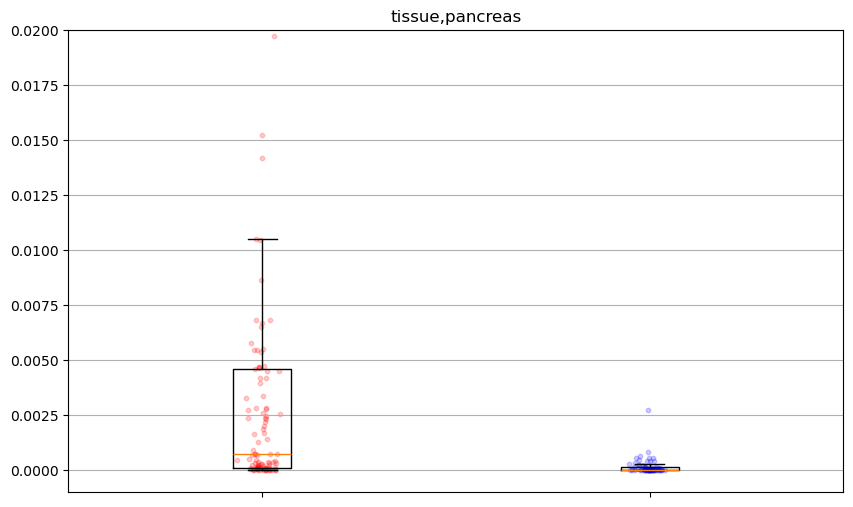

Median value of sum of expression in WGD: 0.00073
Median value of sum of expression in SSD (pre 2R): 2e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5117540687160941, pvalue=1.3014070570735112e-11, statistic_location=0.00013669985938564663, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7432.0, pvalue=1.3138191861974105e-15)


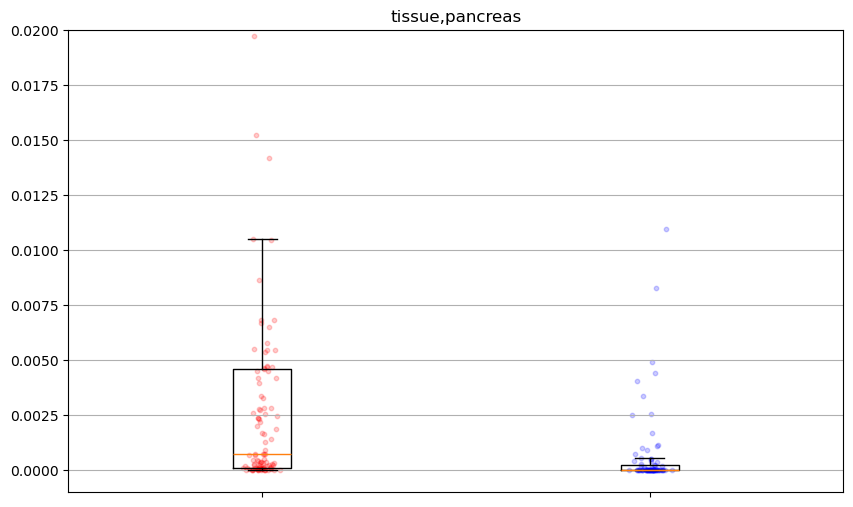

Median value of sum of expression in WGD: 0.00073
Median value of sum of expression in SSD (post 2R): 1e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6078296703296703, pvalue=7.507936090388264e-18, statistic_location=1.5481200227498105e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8364.0, pvalue=4.164374675123595e-15)


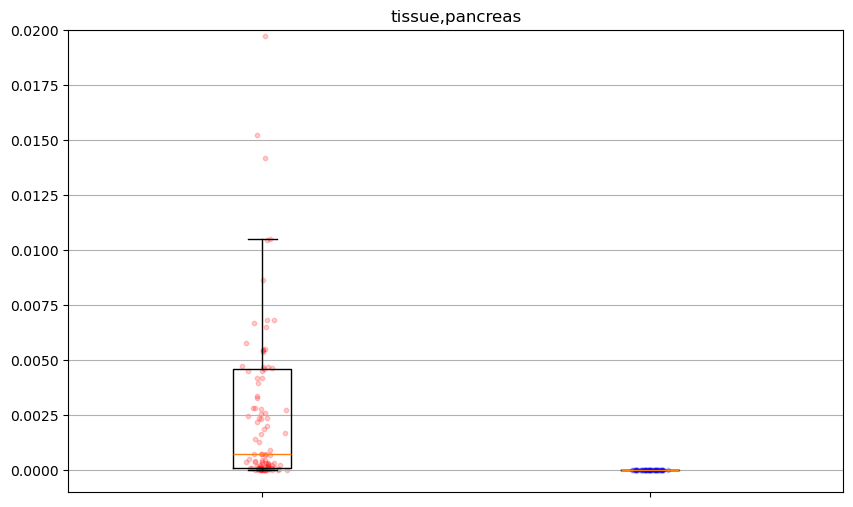

Median value of sum of expression in WGD: 0.00073
Median value of sum of expression in SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.9464285714285714, pvalue=4.206282589547634e-36, statistic_location=2.7380399043724774e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5737.0, pvalue=1.842360915450539e-23)


In [52]:
label = 'tissue,pancreas'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Tissue: Testis

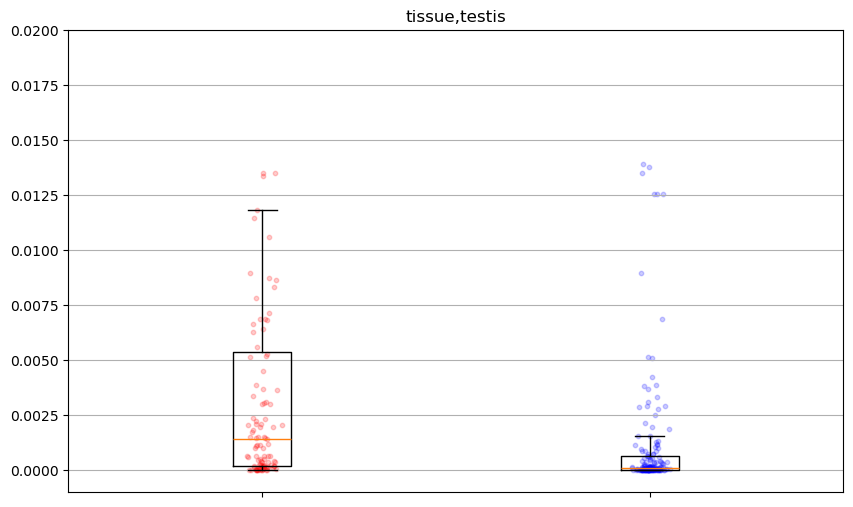

Median value of sum of expression in WGD: 0.001423
Median value of sum of expression in SSD: 9.9e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4089696223316913, pvalue=9.813364587811806e-11, statistic_location=0.00017734937033330332, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=14228.0, pvalue=5.124688303549517e-11)


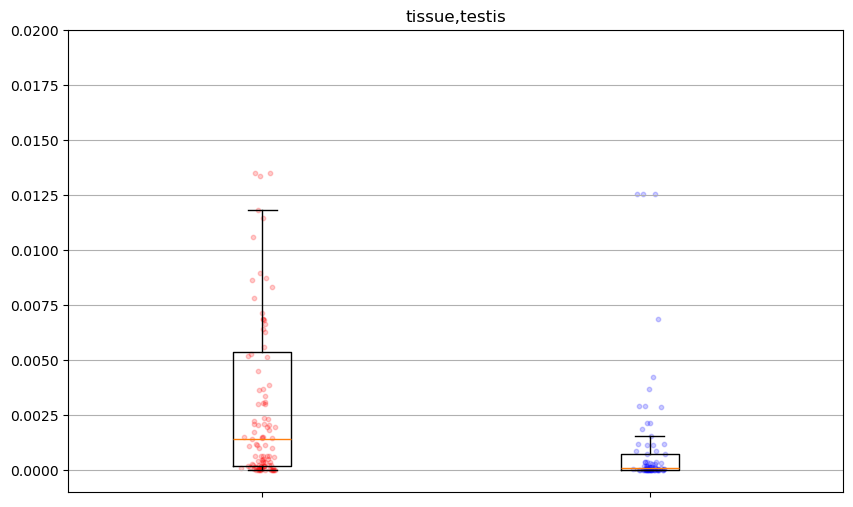

Median value of sum of expression in WGD: 0.001423
Median value of sum of expression in SSD (pre 2R): 9.4e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.40382007233273054, pvalue=2.7215157293494644e-07, statistic_location=0.0003818919846886966, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6494.0, pvalue=3.791694912700918e-08)


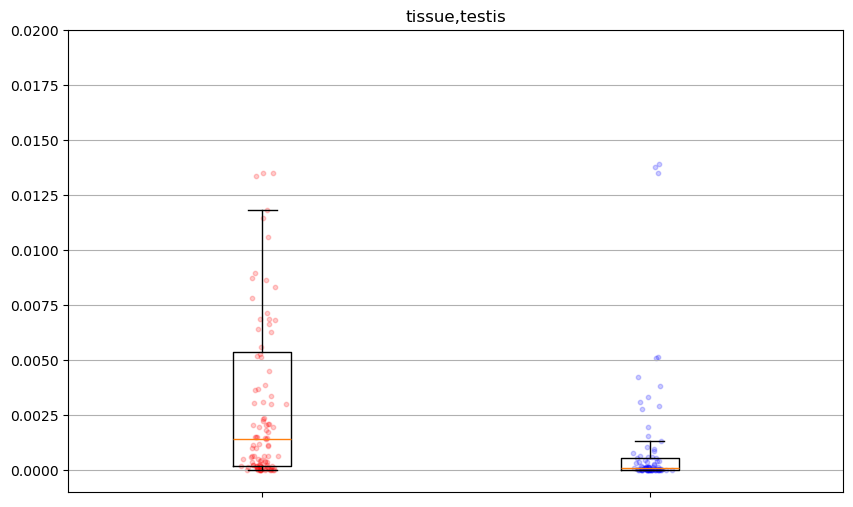

Median value of sum of expression in WGD: 0.001423
Median value of sum of expression in SSD (post 2R): 9.8e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4230769230769231, pvalue=1.3498827357340769e-08, statistic_location=0.00016399494120817213, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7535.0, pvalue=4.6768473016388164e-09)


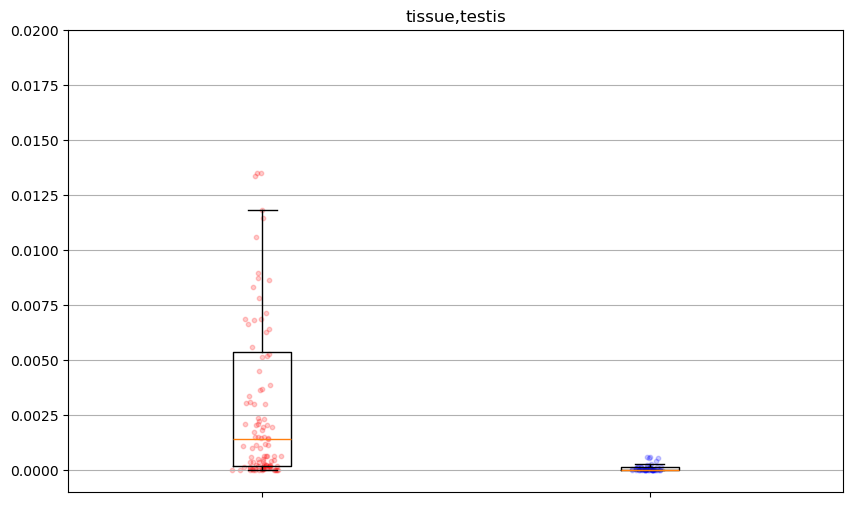

Median value of sum of expression in WGD: 0.001423
Median value of sum of expression in SSD (Mir-430): 2.5e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6510989010989011, pvalue=8.18265027402119e-15, statistic_location=0.00016399494120817213, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5009.0, pvalue=1.2764554105533482e-13)


In [53]:
label = 'tissue,testis'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Tissue: Brain

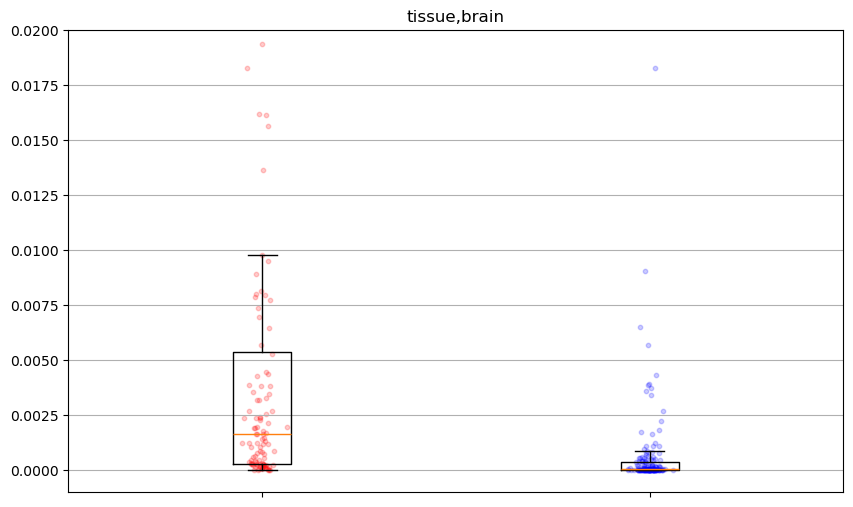

Median value of sum of expression in WGD: 0.001654
Median value of sum of expression in SSD: 3.3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5582922824302134, pvalue=3.997488161003113e-20, statistic_location=0.00018115192375997588, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=16340.0, pvalue=4.421865478434874e-22)


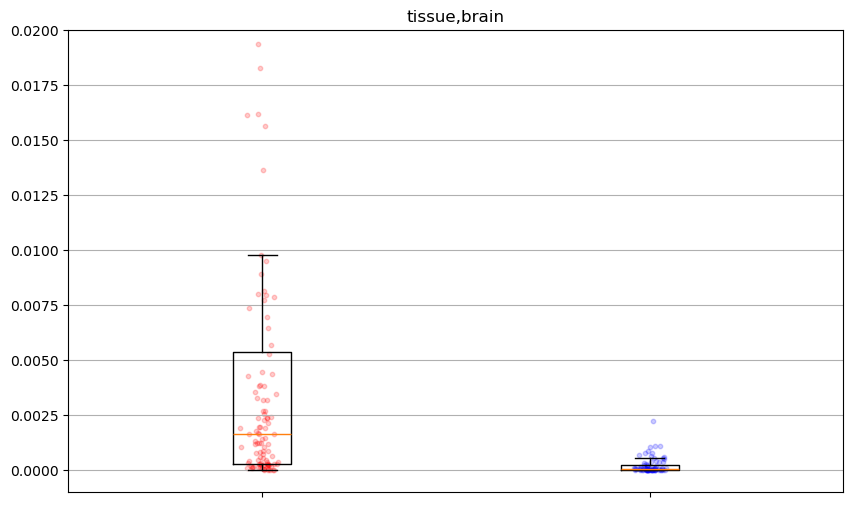

Median value of sum of expression in WGD: 0.001654
Median value of sum of expression in SSD (pre 2R): 5.4e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6002486437613019, pvalue=4.190102851785843e-16, statistic_location=0.00016702087277734279, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7763.0, pvalue=7.118867712273309e-19)


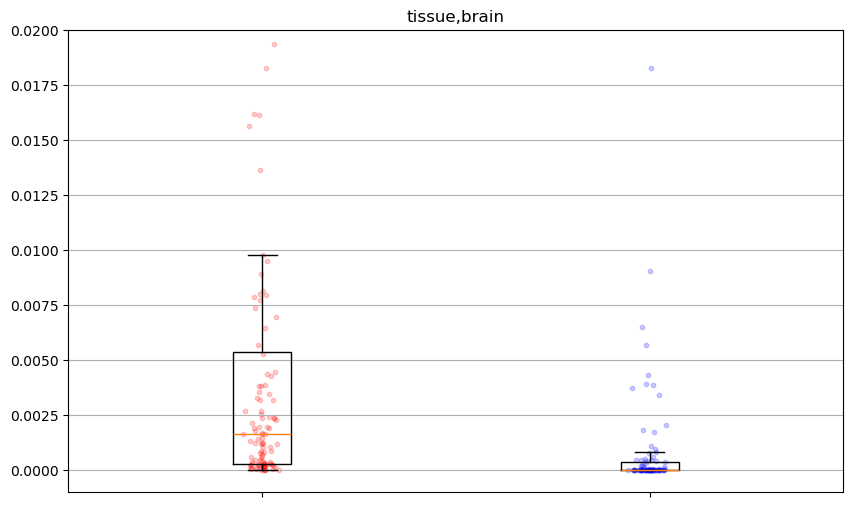

Median value of sum of expression in WGD: 0.001654
Median value of sum of expression in SSD (post 2R): 1.3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6146978021978022, pvalue=2.7930503094698045e-18, statistic_location=5.0638309676179514e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8593.0, pvalue=4.463583553345709e-17)


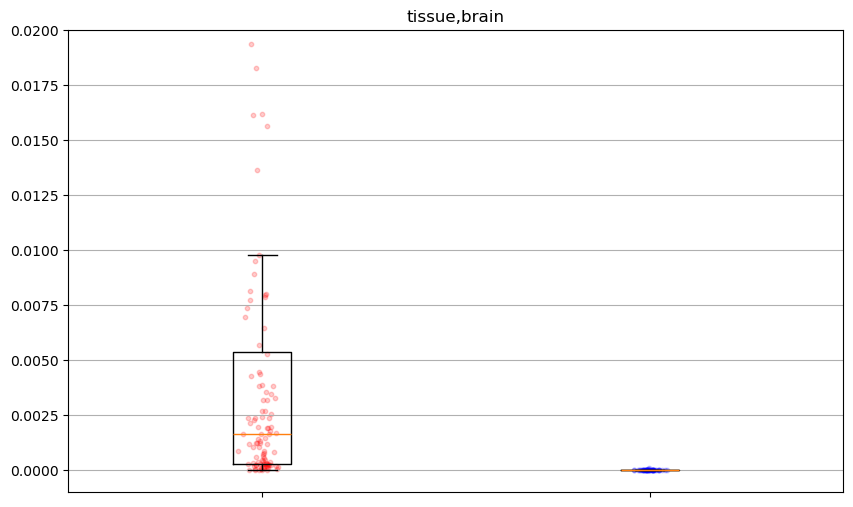

Median value of sum of expression in WGD: 0.001654
Median value of sum of expression in SSD (Mir-430): 6e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.9361263736263736, pvalue=7.268358140285822e-35, statistic_location=5.0638309676179514e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5740.0, pvalue=1.6555545149765094e-23)


In [54]:
label = 'tissue,brain'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

_________________

## Cell lines

In [55]:
cl = df_o.columns[df_o.columns.str.startswith('cell_line')].tolist()
cl

['cell_line,NCI_60_cancer_panel,NCI_60_cancer_panel,mean',
 'cell_line,adipose,adipose,mean',
 'cell_line,airway,HS840,mean',
 'cell_line,airway,epithelium,mean',
 'cell_line,airway,pharynx,mean',
 'cell_line,artery,artery,mean',
 'cell_line,ascites,AD3,mean',
 'cell_line,bladder,bladder,mean',
 'cell_line,blood,MEC1,mean',
 'cell_line,blood,Molm14,mean',
 'cell_line,blood,THP,mean',
 'cell_line,blood,blood,mean',
 'cell_line,blood,plasma,mean',
 'cell_line,blood,serum,mean',
 'cell_line,bone,143B,mean',
 'cell_line,bone,HFO,mean',
 'cell_line,bone,U2OS,mean',
 'cell_line,bone,bone,mean',
 'cell_line,bone_marrow,BL_cell_line,mean',
 'cell_line,bone_marrow,BMSC,mean',
 'cell_line,bone_marrow,HAP1,mean',
 'cell_line,bone_marrow,K562,mean',
 'cell_line,bone_marrow,SHSY5Y,mean',
 'cell_line,bowel,Caco,mean',
 'cell_line,bowel,HCT116,mean',
 'cell_line,bowel,HT29,mean',
 'cell_line,bowel,PEO1,mean',
 'cell_line,bowel,colon,mean',
 'cell_line,brain,HOG,mean',
 'cell_line,brain,NCH421k,mean',

## Cell line: Blood

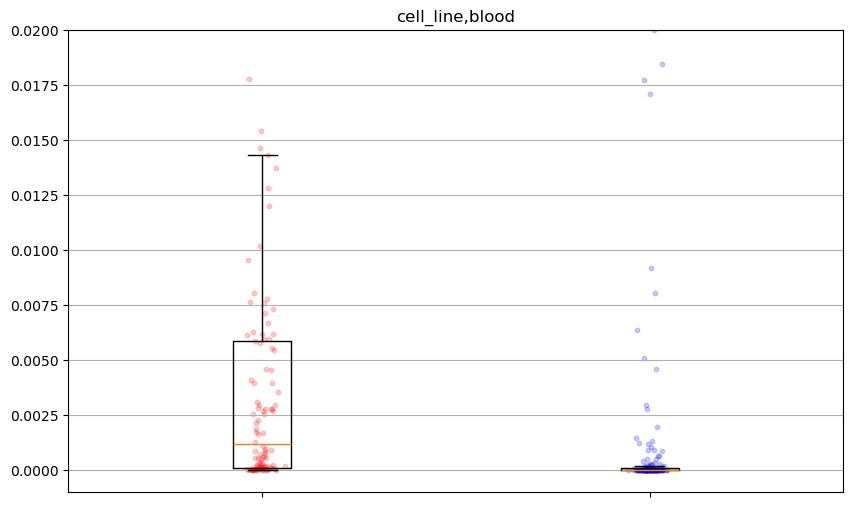

Median value of sum of expression in WGD: 0.001186
Median value of sum of expression in SSD: 4e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5818965517241379, pvalue=6.096431031348051e-22, statistic_location=3.547960855012053e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=16471.0, pvalue=6.670535866178417e-23)


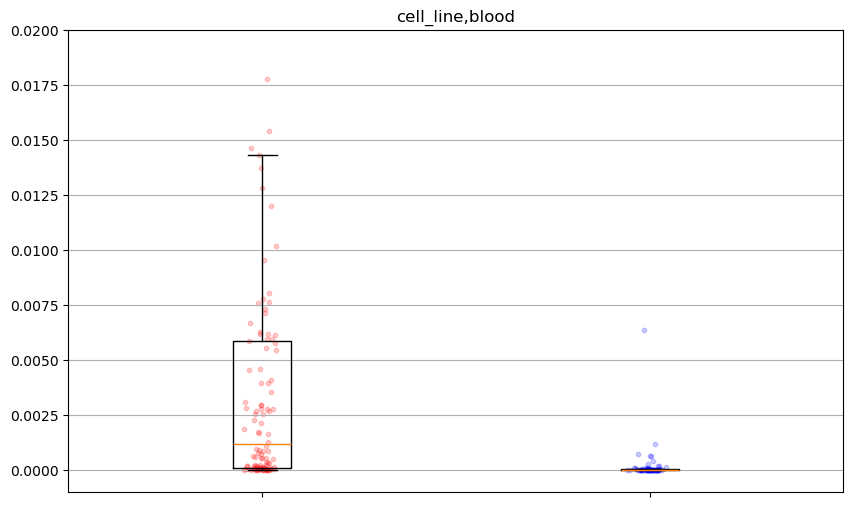

Median value of sum of expression in WGD: 0.001186
Median value of sum of expression in SSD (pre 2R): 5e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6419529837251357, pvalue=1.508649877728036e-18, statistic_location=5.1730793963476454e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7932.0, pvalue=1.1396793917702159e-20)


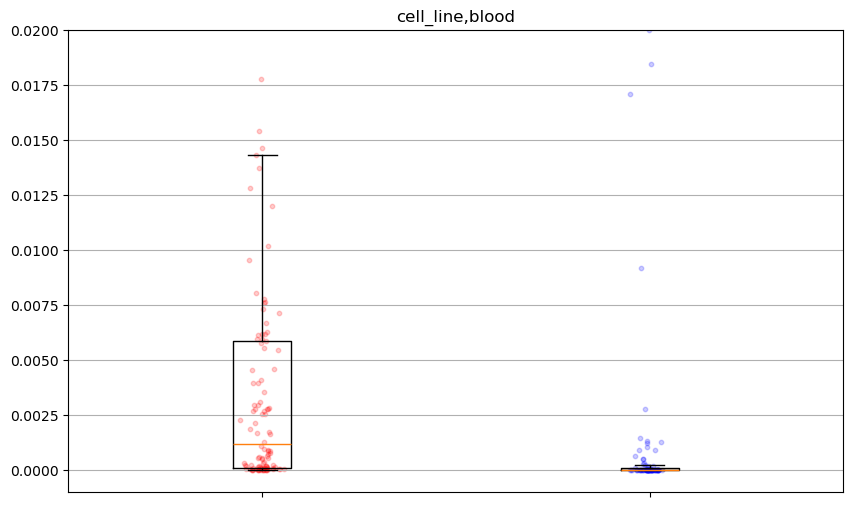

Median value of sum of expression in WGD: 0.001186
Median value of sum of expression in SSD (post 2R): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6497252747252747, pvalue=1.492237747076417e-20, statistic_location=1.5609337625855187e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8587.0, pvalue=5.046030460947087e-17)


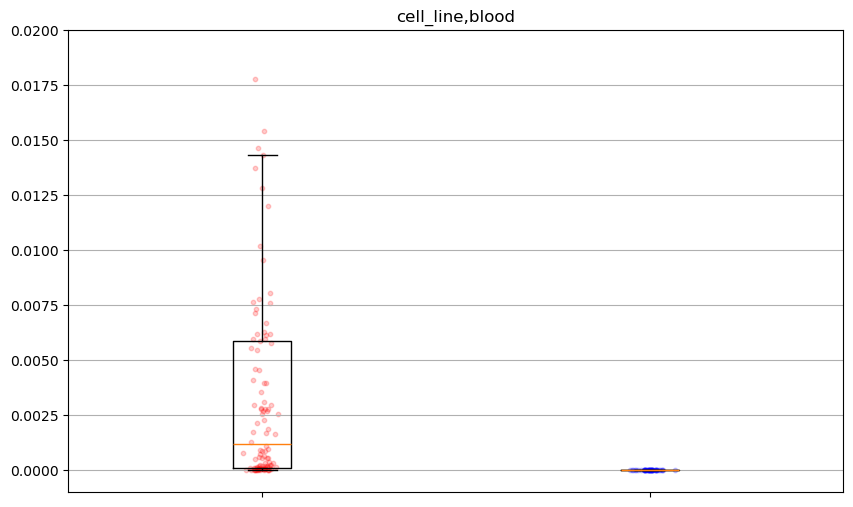

Median value of sum of expression in WGD: 0.001186
Median value of sum of expression in SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.9539835164835165, pvalue=6.6346309489781045e-37, statistic_location=6.128156928423849e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5760.0, pvalue=8.094059084779366e-24)


In [56]:
label = 'cell_line,blood'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Cell line: Liver

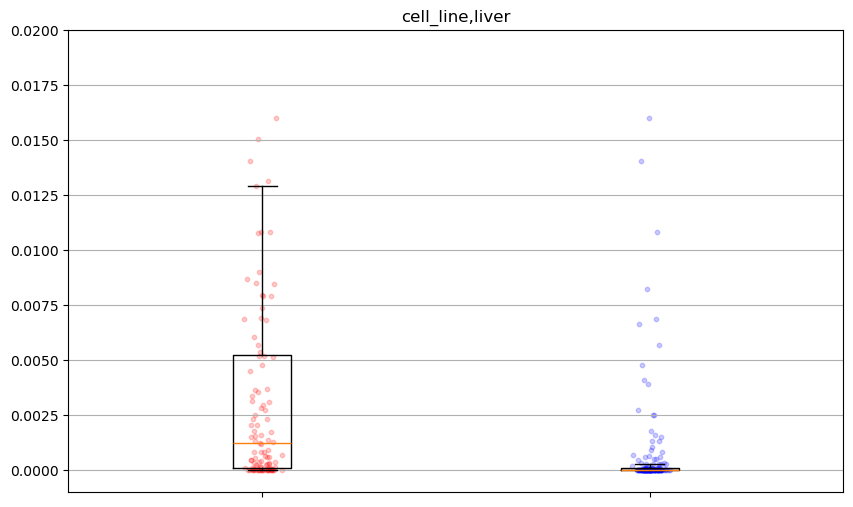

Median value of sum of expression in WGD: 0.001213
Median value of sum of expression in SSD: 3e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5041050903119869, pvalue=2.5873921392641684e-16, statistic_location=5.079465868618367e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15916.0, pvalue=1.569750390013418e-19)


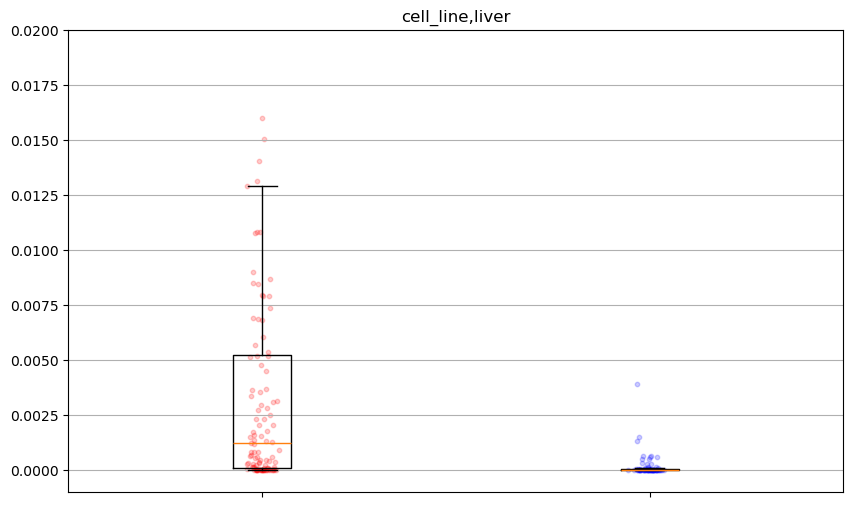

Median value of sum of expression in WGD: 0.001213
Median value of sum of expression in SSD (pre 2R): 6e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5705244122965641, pvalue=1.7490244695974853e-14, statistic_location=5.079465868618367e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7507.0, pvalue=2.555864146427858e-16)


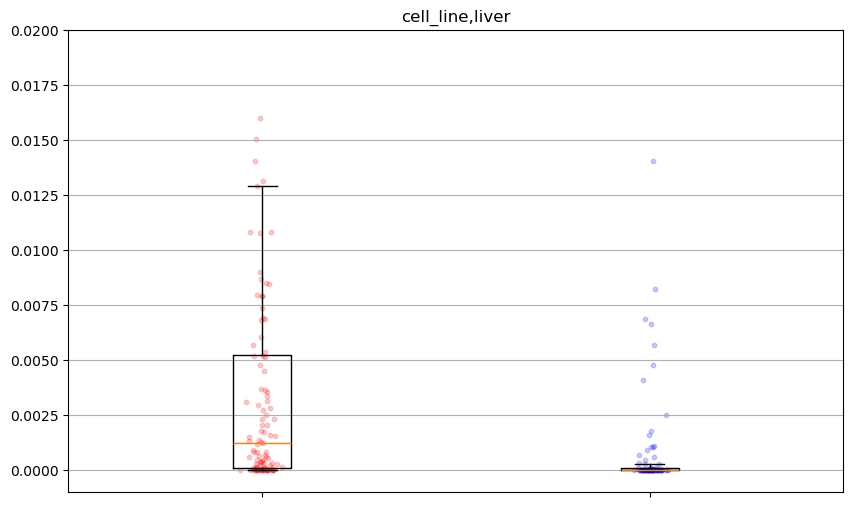

Median value of sum of expression in WGD: 0.001213
Median value of sum of expression in SSD (post 2R): 1e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.570054945054945, pvalue=1.2770778760174022e-15, statistic_location=6.198211568316053e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8344.0, pvalue=6.1015232949170166e-15)


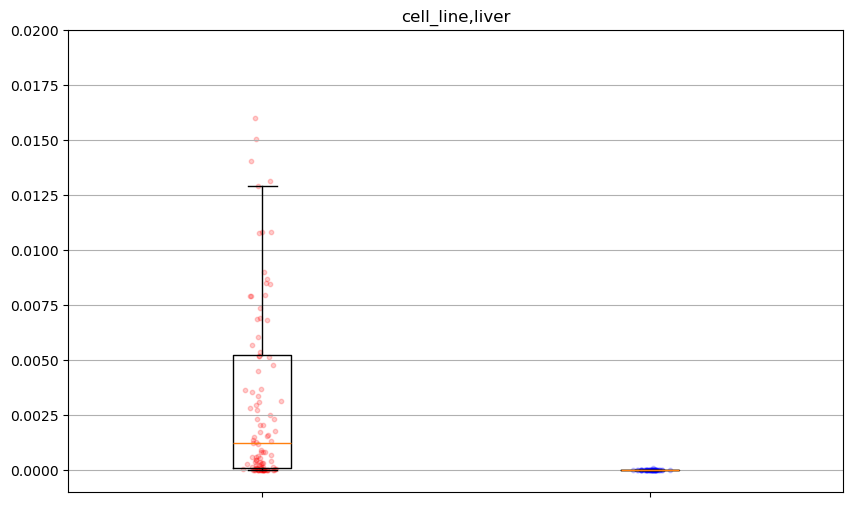

Median value of sum of expression in WGD: 0.001213
Median value of sum of expression in SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.915521978021978, pvalue=7.005479907454228e-33, statistic_location=1.1833863877008493e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5692.0, pvalue=9.037367585523773e-23)


In [57]:
label = 'cell_line,liver'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Cell line: Nerve

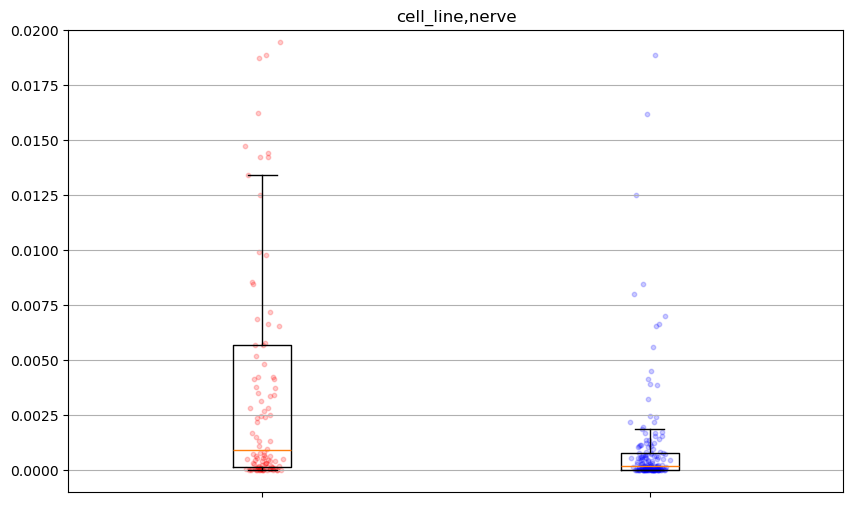

Median value of sum of expression in WGD: 0.000895
Median value of sum of expression in SSD: 0.000167
Kolmogorov-Smirnov test:	KstestResult(statistic=0.33723316912972084, pvalue=2.1386375882120001e-07, statistic_location=0.002184328286528515, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=13329.0, pvalue=1.5173206400655608e-07)


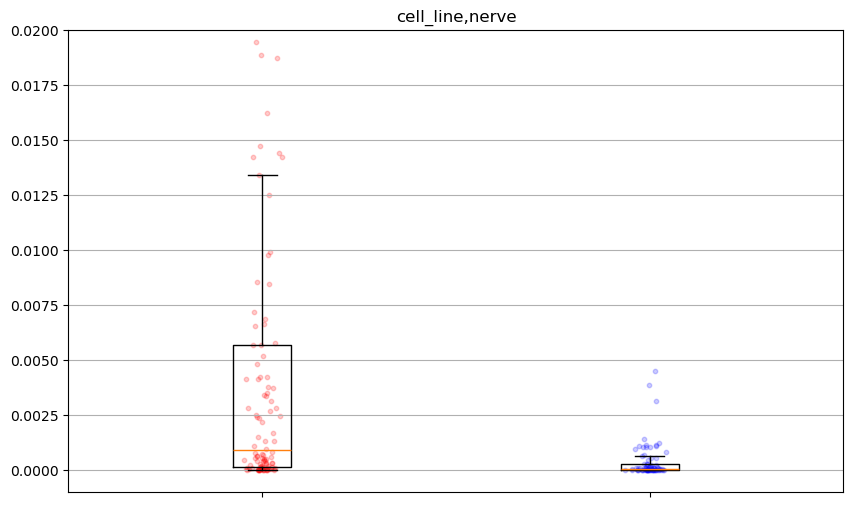

Median value of sum of expression in WGD: 0.000895
Median value of sum of expression in SSD (pre 2R): 7.1e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.43806509945750455, pvalue=1.551252639753838e-08, statistic_location=0.00028559643450716955, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6843.0, pvalue=1.2941596555460363e-10)


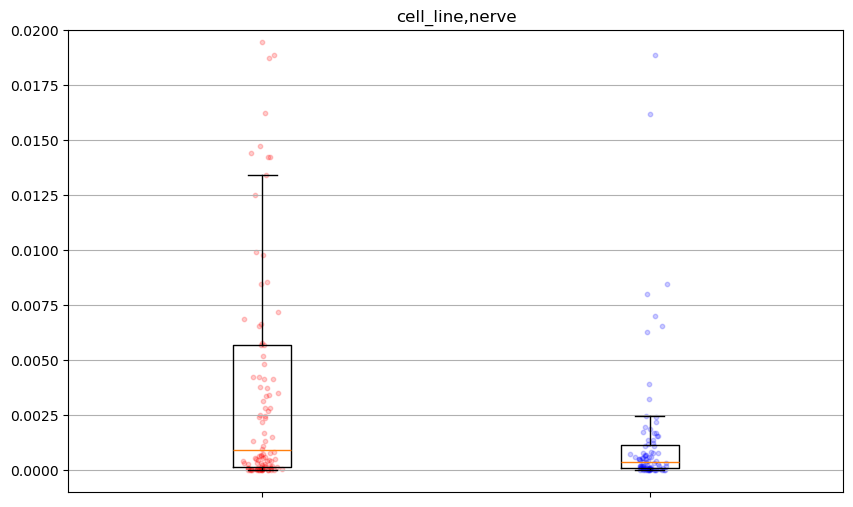

Median value of sum of expression in WGD: 0.000895
Median value of sum of expression in SSD (post 2R): 0.000348
Kolmogorov-Smirnov test:	KstestResult(statistic=0.32074175824175827, pvalue=4.387387215879889e-05, statistic_location=0.0024420233601418475, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6505.0, pvalue=0.0007149096210949117)


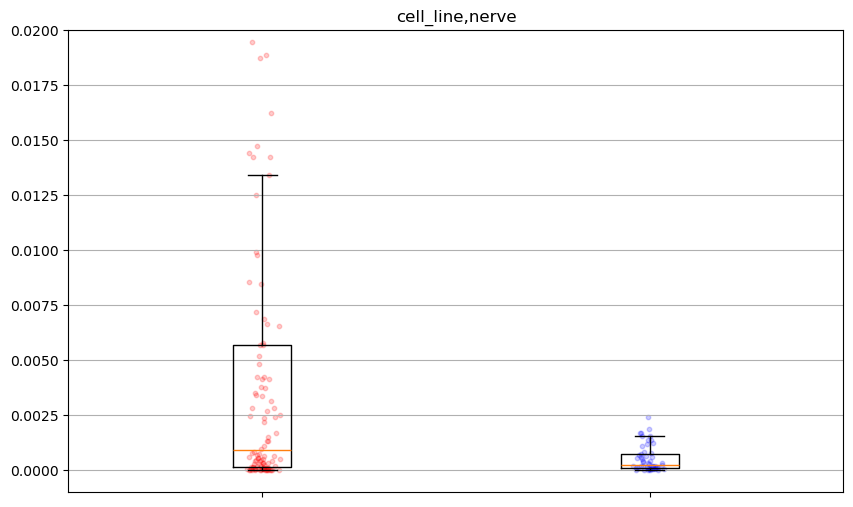

Median value of sum of expression in WGD: 0.000895
Median value of sum of expression in SSD (Mir-430): 0.000249
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4271978021978022, pvalue=2.3306853327208315e-06, statistic_location=0.0018735310037091598, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=3864.0, pvalue=0.0007726737601900615)


In [58]:
label = 'cell_line,nerve'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Cell line: Stem cells

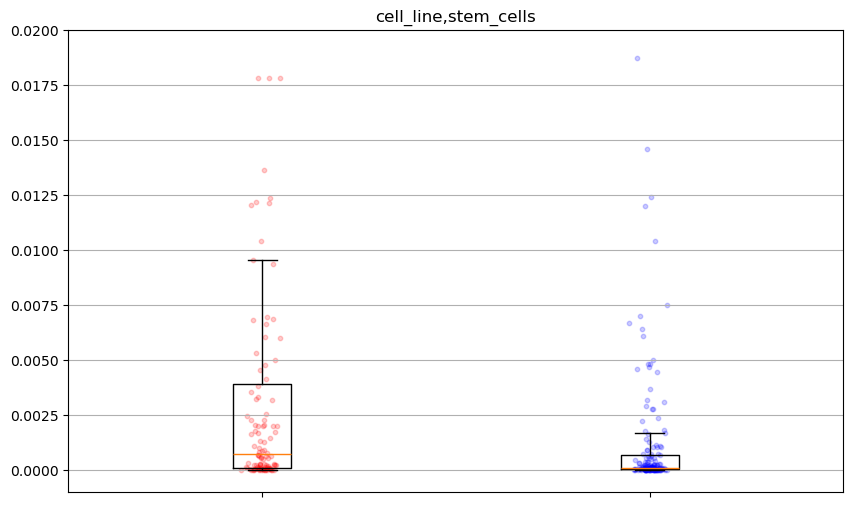

Median value of sum of expression in WGD: 0.000741
Median value of sum of expression in SSD: 0.000118
Kolmogorov-Smirnov test:	KstestResult(statistic=0.3081896551724138, pvalue=3.123302333927943e-06, statistic_location=0.00021873563815075832, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=12998.0, pvalue=1.8828462107251262e-06)


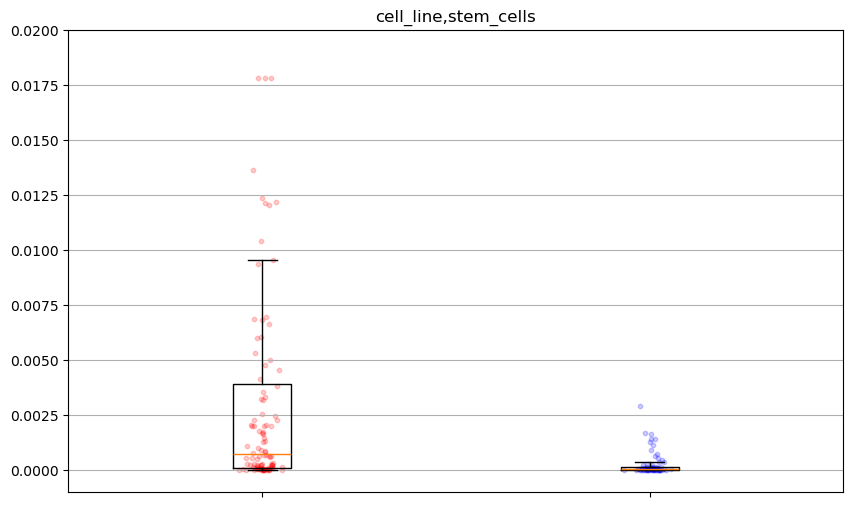

Median value of sum of expression in WGD: 0.000741
Median value of sum of expression in SSD (pre 2R): 5.5e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4812386980108499, pvalue=2.8596382791349244e-10, statistic_location=0.00016370502086035835, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6976.0, pvalue=1.1906471266097141e-11)


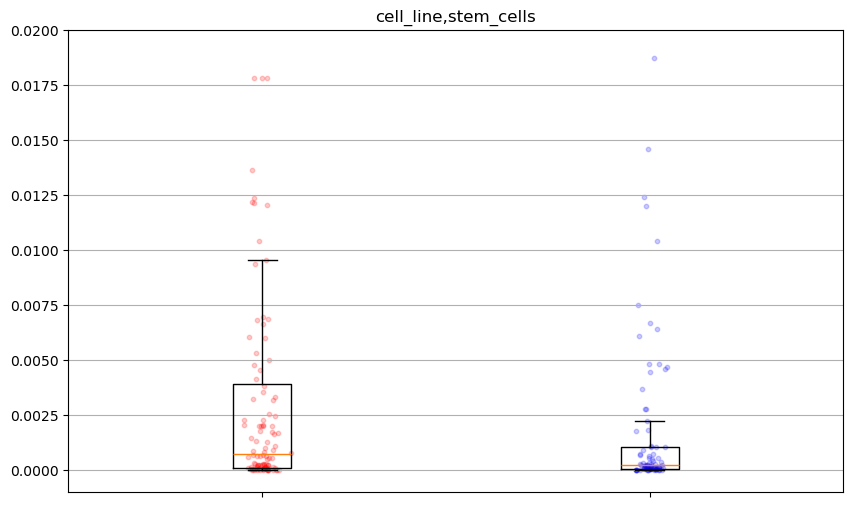

Median value of sum of expression in WGD: 0.000741
Median value of sum of expression in SSD (post 2R): 0.000216
Kolmogorov-Smirnov test:	KstestResult(statistic=0.23076923076923078, pvalue=0.007713020720525266, statistic_location=0.0005415318559207934, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6168.0, pvalue=0.010047686049017507)


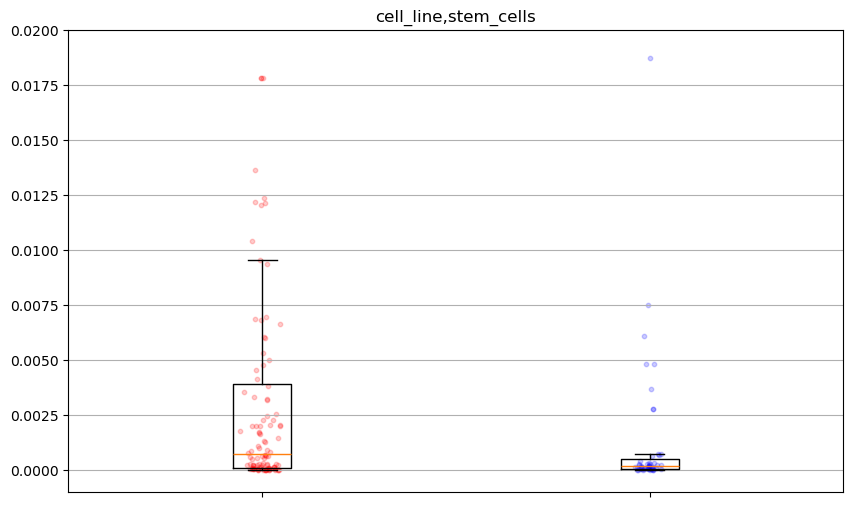

Median value of sum of expression in WGD: 0.000741
Median value of sum of expression in SSD (Mir-430): 0.000173
Kolmogorov-Smirnov test:	KstestResult(statistic=0.33035714285714285, pvalue=0.000595806108770099, statistic_location=0.0004315771129077668, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=3744.0, pvalue=0.0032996680687985974)


In [59]:
label = 'cell_line,stem_cells'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

## Cell line: Lung

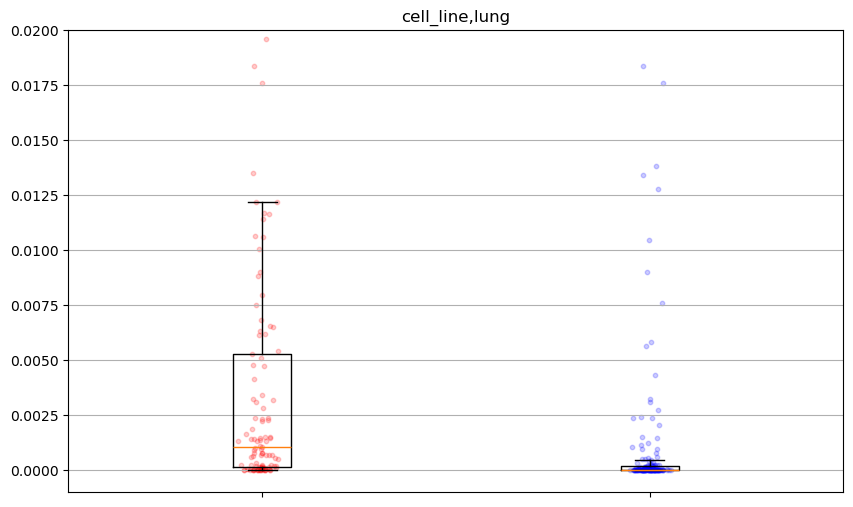

Median value of sum of expression in WGD: 0.001068
Median value of sum of expression in SSD: 1.8e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.46839080459770116, pvalue=4.6162565649377695e-14, statistic_location=0.00012554925019246218, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=15233.0, pvalue=9.031251717041772e-16)


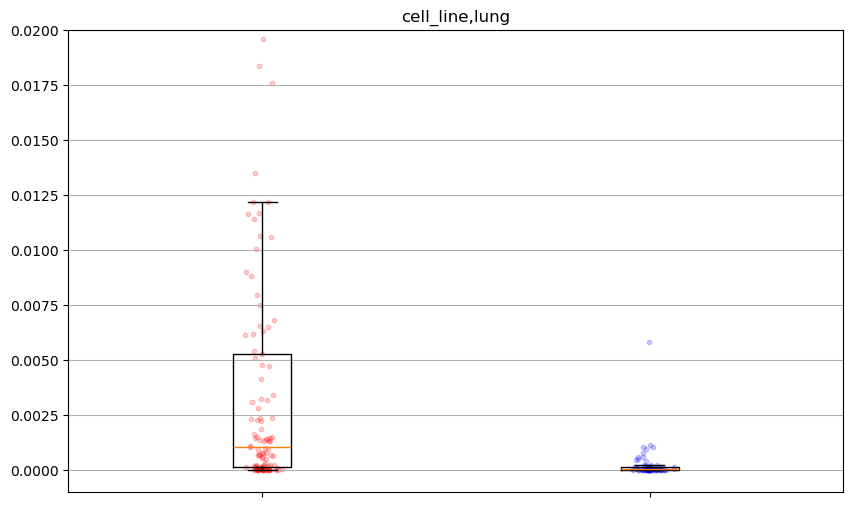

Median value of sum of expression in WGD: 0.001068
Median value of sum of expression in SSD (pre 2R): 5.3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5311934900542495, pvalue=1.5087665865977728e-12, statistic_location=0.0005917032607014355, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=7170.0, pvalue=2.9435871145665704e-13)


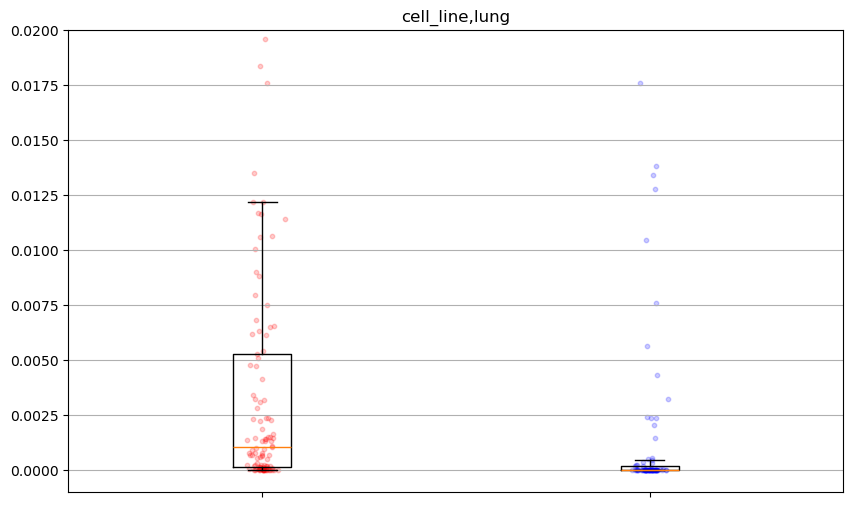

Median value of sum of expression in WGD: 0.001068
Median value of sum of expression in SSD (post 2R): 3e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5425824175824175, pvalue=4.065097449278463e-14, statistic_location=2.839845251694749e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=8068.0, pvalue=9.417274406101296e-13)


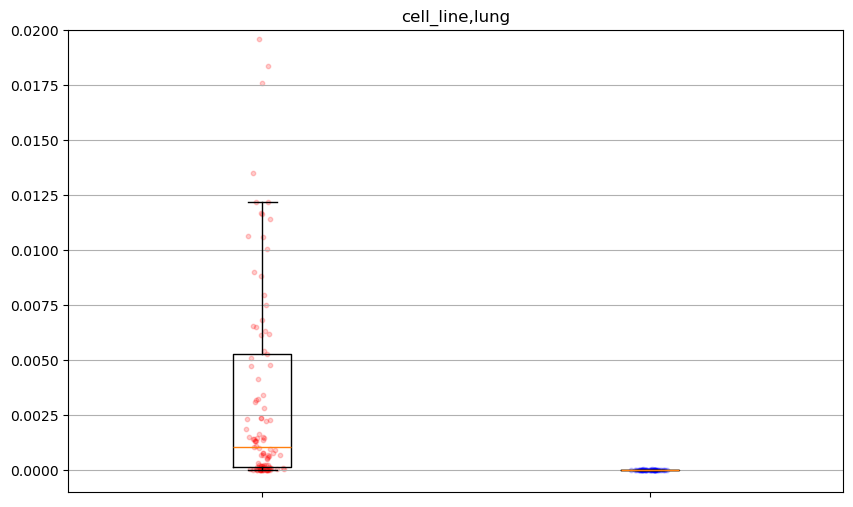

Median value of sum of expression in WGD: 0.001068
Median value of sum of expression in SSD (Mir-430): 1e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.8097527472527473, pvalue=3.8016658945347315e-24, statistic_location=2.4413772835864394e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5502.0, pvalue=5.653801806504511e-20)


In [60]:
label = 'cell_line,lung'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)